In [2]:
import os, json, ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from scipy import stats
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')
sns.set_context("poster")
sns.set_style("ticks")

curr_wd = os.getcwd()

# Figure 1: Simulation results from toy models

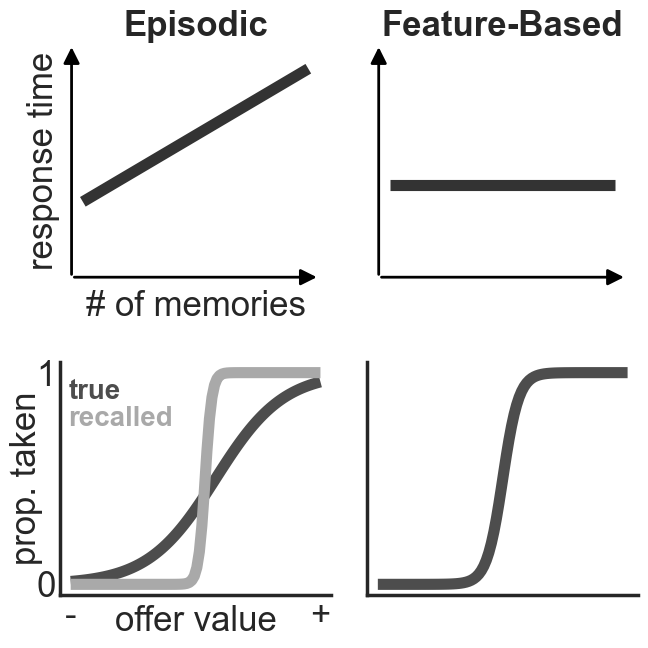

In [164]:
ep_sim = pd.read_csv(curr_wd + "/data/episodic_model_sim.csv")
fb_sim = pd.read_csv(curr_wd + "/data/feature_model_sim.csv")

def plot_sim_rts(data, model_type, ax):
    """Plot RT data for simulated results"""
    if model_type == 'episodic':
        # Generate x values for plotting
        x = np.linspace(1, 6, 6)
        
        # Calculate binned statistics
        bin_means, bin_edges, _ = stats.binned_statistic(
            data['n_memories'], np.log(data['rt']),
            statistic='mean', bins=6)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = bin_edges[1:] - bin_width/2
        
        # Calculate standard error for error bars
        bin_std, _, _ = stats.binned_statistic(
            data['n_memories'], np.log(data['rt']),
            statistic=stats.sem, bins=6)
                
        # Fit polynomial and create function
        z = np.polyfit(bin_centers, bin_means, 1)
        p = np.poly1d(z)  # Save the polynomial function
        
        with plt.rc_context({'lines.solid_capstyle': 'butt'}):

            # Thicker regression lines
            # ax.plot(x, p(x), color='k', linewidth=10, zorder=1)  # Increased from 5
            ax.plot(x, p(x), color='#333333', linewidth=8, zorder=2)  # Increased from 3
        
    else:  # feature-based model

        with plt.rc_context({'lines.solid_capstyle': 'butt'}):

            # Plot horizontal line with thicker style
            mean_rt = np.log(data['rt'].mean())
            ax.plot([1, 6], [mean_rt, mean_rt], color='#333333', linewidth=8, zorder=2)
    
    # Remove all spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # Remove all ticks and labels
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Set axis limits
    ax.set_xlim(0.5, 6.5)
    ax.set_ylim(0, 1.75)
    
    # Add arrows
    # X-axis arrow
    ax.annotate('', xy=(6.25, 0), xytext=(0.75, 0),
                arrowprops=dict(arrowstyle='-|>',
                                facecolor='black',
                              linewidth=2,
                              color='black'))
    
    # Y-axis arrow
    ax.annotate('', xy=(0.75, 1.75), xytext=(0.75, 0),
                arrowprops=dict(arrowstyle='-|>',
                                facecolor='black',
                              linewidth=2,
                              color='black'))
    
    # Add labels with more space from arrows
    if model_type == 'episodic':
        ax.text(3.5, -0.1, '# of memories',
                ha='center', va='top', size=25)
        ax.text(0.5, 0.875, 'response time',
                ha='right', va='center', size=25,
                rotation=90)
    
def plot_sim_choices(data, model_type, ax):
    """Plot choice data for simulated results"""
    # Generate x values for plotting
    x = np.linspace(-3, 3, 100).reshape(-1, 1)
    
    if model_type == 'episodic':

        # Standardize the input values
        true_values = (data['true_value'] - data['true_value'].mean()) / data['true_value'].std()
        recalled_values = (data['recalled_value'] - data['recalled_value'].mean()) / data['recalled_value'].std()

        # Fit logistic regression with reduced regularization
        true_log = LogisticRegression()  # Increased C to reduce regularization
        X_true = true_values.values.reshape(-1, 1)
        true_log.fit(X_true, data['choice'])
        
        recalled_log = LogisticRegression()
        X_recalled = recalled_values.values.reshape(-1, 1)
        recalled_log.fit(X_recalled, data['choice'])
        
        # Get coefficients and intercepts
        true_coef = true_log.coef_[0][0]
        true_intercept = true_log.intercept_[0] + 0.5
        recalled_coef = recalled_log.coef_[0][0]
        recalled_intercept = recalled_log.intercept_[0]
        
        # Calculate predicted probabilities using sigmoid function
        def sigmoid(x, coef, intercept):
            return 1 / (1 + np.exp(-(coef * x + intercept)))
        
        y_true = sigmoid(x, true_coef, true_intercept)
        y_recalled = sigmoid(x, recalled_coef, recalled_intercept)

        with plt.rc_context({'lines.solid_capstyle': 'butt'}):

            # ax.plot(x, y_true, color='k', linewidth=10, zorder=1)  # Increased from 7.5
            ax.plot(x, y_true, color='.3', linewidth=8, label='True', zorder=2)  # Increased from 5
            # ax.plot(x, y_recalled, color='k', linewidth=10, zorder=1)  # Increased from 7.5
            ax.plot(x, y_recalled, color='#A9A9A9', linewidth=8, label='Recalled', zorder=2)  # Increased from 5
                
    else:  # feature-based model
        
        # Fit and plot logistic regression
        true_log = LogisticRegression()
        true_log.fit(data['true_value'].values.reshape(-1,1), data['choice'])
        y_true = true_log.predict_proba(x.reshape(-1,1))[:,1]
        
        # Fit and plot logistic regression
        recalled_log = LogisticRegression()
        recalled_log.fit(data['recalled_value'].values.reshape(-1,1), data['choice'])
        y_recalled = recalled_log.predict_proba(x.reshape(-1,1))[:,1]

        with plt.rc_context({'lines.solid_capstyle': 'butt'}):

            ax.plot(x, y_true, color='.3', linewidth=8, label='True', zorder=2)  # Increased from 5

    # Customize the plot
    if model_type == 'episodic':
        ax.set_xlabel('offer value', size=25, labelpad=-20)
        ax.set_ylabel('prop. taken', size=25, labelpad=-5)
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0, 1])
    ax.set_xlim(-3.25,3.25)
    ax.set_xticks([-3,3])
    if model_type == 'episodic':    
        ax.set_yticklabels([0, 1], size=25)
        ax.set_xticklabels(['-','+'], size=25)
    else:
        ax.set_yticklabels([], size=25)
        ax.set_xticklabels([], size=25)
    ax.tick_params(axis='both', length=0)
    if model_type == 'episodic':
        ax.text(-3.05, 0.875, 'true', color='.3', size=20, fontweight='bold')
        ax.text(-3.05, 0.75, 'recalled', color='#A9A9A9', size=20, fontweight='bold')
    sns.despine(ax=ax)

# Create the overall figure
fig = plt.figure(figsize=(7, 7))

# Create subplot grid
gs = plt.GridSpec(2, 2)

# Create four subplot axes
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])

# Create the plots
plot_sim_rts(ep_sim, 'episodic', ax1)
plot_sim_rts(fb_sim, 'feature', ax2)
plot_sim_choices(ep_sim, 'episodic', ax3)
plot_sim_choices(fb_sim, 'feature', ax4)

# Add titles
ax1.set_title('Episodic', size=25, fontweight='bold')
ax2.set_title('Feature-Based', size=25, fontweight='bold')

plt.tight_layout()
plt.savefig("figures/Figure1C.pdf")

# Figure 2: Experiments 1A, 1B, 2

In [ ]:
# Data Experiment 1A
data_1a = pd.read_csv(curr_wd + "/data/choiceDataMemValue_1A.csv")
data_1a["value_z"] = zscore(data_1a["value"])
data_1a["recalled_mem_value_z"] = zscore(data_1a["recalled_mem_value"])
data_1a = data_1a.dropna()
data_1a["elpd_diff"] = pd.read_csv(curr_wd + "/output/choice_elpd_diff_raw_1A.csv")["elpd_diff"]
data_1a_full = pd.read_csv(curr_wd + "/data/choiceDataFull_1A.csv")
choice_effects_1a = pd.read_csv(curr_wd + "/output/choice_effects_1A.csv")
true_choice_effects_1a = choice_effects_1a[choice_effects_1a.model == "true"]
mem_choice_effects_1a = choice_effects_1a[choice_effects_1a.model == "memory"]
elpd_1a = pd.read_csv(curr_wd + "/output/choice_elpd_diff_1A.csv")
rt_effects_1a = pd.read_csv(curr_wd + "/output/rt_effects_1A.csv")

# Data Experiment 1B
data_1b = pd.read_csv(curr_wd + "/data/choiceDataMemValue_1B.csv")
data_1b["value_z"] = zscore(data_1b["value"])
data_1b["recalled_mem_value_z"] = zscore(data_1b["recalled_mem_value"])
data_1b = data_1b.dropna()
data_1b["elpd_diff"] = pd.read_csv(curr_wd + "/output/choice_elpd_diff_raw_1B.csv")["elpd_diff"]
data_1b_full = pd.read_csv(curr_wd + "/data/choiceDataFull_1B.csv")
choice_effects_1b = pd.read_csv(curr_wd + "/output/choice_effects_1B.csv")
true_choice_effects_1b = choice_effects_1b[choice_effects_1b.model == "true"]
mem_choice_effects_1b = choice_effects_1b[choice_effects_1b.model == "memory"]
elpd_1b = pd.read_csv(curr_wd + "/output/choice_elpd_diff_1B.csv")
rt_effects_1b = pd.read_csv(curr_wd + "/output/rt_effects_1B.csv")

# Data Experiment 2
data_2 = pd.read_csv(curr_wd + "/data/choiceDataMemValue_2.csv")
data_2["value_z"] = zscore(data_2["value"])
data_2["recalled_mem_value_z"] = zscore(data_2["recalled_mem_value"])
data_2 = data_2.dropna()
data_2["elpd_diff"] = pd.read_csv(curr_wd + "/output/choice_elpd_diff_raw_2.csv")["elpd_diff"]
data_2_full = pd.read_csv(curr_wd + "/data/choiceDataFull_2.csv")
choice_effects_2 = pd.read_csv(curr_wd + "/output/choice_effects_2.csv")
true_choice_effects_2 = choice_effects_2[choice_effects_2.model == "true"]
mem_choice_effects_2 = choice_effects_2[choice_effects_2.model == "memory"]
elpd_2 = pd.read_csv(curr_wd + "/output/choice_elpd_diff_2.csv")
rt_effects_2 = pd.read_csv(curr_wd + "/output/rt_effects_2.csv")

# Load all of the recall data as well
def calc_recall_rate(recall_data):
    if "multi_time" in recall_data:
        grp_vars = ["Experiment", "wid", "multi_time"]
        new_cols = ["Experiment", "wid", "multi_time", "total_n_recalled", "total_n_items"]
    else:
        grp_vars = ["Experiment", "wid"]
        new_cols = ["Experiment", "wid", "total_n_recalled", "total_n_items"]
    r = recall_data.groupby(grp_vars).agg({
        "recalled": ["sum", "size"]  # sum of True values and total count
    }).reset_index()
    # Flatten multi-level column names
    r.columns = new_cols
    r["recall_rate"] = r["total_n_recalled"] / r["total_n_items"]
    return r

def normalize_preserve_zero(df, columns):
    max_abs = max(abs(df[columns]).max())
    df_norm = df.copy()
    for col in columns:
        df_norm[col] = df[col] / max_abs
    return df_norm

# 1A
full_recall_1a = pd.read_csv(curr_wd + "/data/recallData_1A.csv")
full_recall_1a["Experiment"] = "1A"
recall_1a = calc_recall_rate(full_recall_1a)
valmem_1a_norm = normalize_preserve_zero(full_recall_1a[full_recall_1a.recalled == True],
                                         ['outcome', 'remembered_outcome'])
# 1B
full_recall_1b = pd.read_csv(curr_wd + "/data/recallData_1B.csv")
full_recall_1b["Experiment"] = "1B"
recall_1b = calc_recall_rate(full_recall_1b)
valmem_1b_norm = normalize_preserve_zero(full_recall_1b[full_recall_1b.recalled == True],
                                         ['outcome', 'remembered_outcome'])
# 2
full_recall_2 = pd.read_csv(curr_wd + "/data/recallData_2.csv")
full_recall_2["Experiment"] = "2"
recall_2 = calc_recall_rate(full_recall_2)
valmem_2_norm = normalize_preserve_zero(full_recall_2[full_recall_2.recalled == True],
                                         ['outcome', 'remembered_outcome'])

# 3A
full_recall_3a = pd.read_csv(curr_wd + "/data/recallData_3A.csv")
full_recall_3a["Experiment"] = "3A"
before_recall_3a = full_recall_3a[full_recall_3a.multi_time == "Before"].reset_index(drop=True)
after_recall_3a = full_recall_3a[full_recall_3a.multi_time == "After"].reset_index(drop=True)
before_valmem_3a_norm = normalize_preserve_zero(before_recall_3a[before_recall_3a.recalled == True],
                                         ['outcome', 'remembered_outcome'])
after_valmem_3a_norm = normalize_preserve_zero(after_recall_3a[after_recall_3a.recalled == True],
                                         ['outcome', 'remembered_outcome'])
before_recall_3a = calc_recall_rate(before_recall_3a)
after_recall_3a = calc_recall_rate(after_recall_3a)
recall_3a = pd.concat([before_recall_3a,after_recall_3a]).reset_index(drop=True)

# 3B
full_recall_3b = pd.read_csv(curr_wd + "/data/recallData_3B.csv")
full_recall_3b["Experiment"] = "3B"
before_recall_3b = full_recall_3b[full_recall_3b.multi_time == "Before"].reset_index(drop=True)
after_recall_3b = full_recall_3b[full_recall_3b.multi_time == "After"].reset_index(drop=True)
before_valmem_3b_norm = normalize_preserve_zero(before_recall_3b[before_recall_3b.recalled == True],
                                         ['outcome', 'remembered_outcome'])
after_valmem_3b_norm = normalize_preserve_zero(after_recall_3b[after_recall_3b.recalled == True],
                                         ['outcome', 'remembered_outcome'])
before_recall_3b = calc_recall_rate(before_recall_3b)
after_recall_3b = calc_recall_rate(after_recall_3b)
recall_3b = pd.concat([before_recall_3b,after_recall_3b]).reset_index(drop=True)

# 4
full_recall_4 = pd.read_csv(curr_wd + "/data/recallData_4.csv")
full_recall_4["Experiment"] = "4"
before_recall_4 = full_recall_4[full_recall_4.multi_time == "Before"].reset_index(drop=True)
after_recall_4 = full_recall_4[full_recall_4.multi_time == "After"].reset_index(drop=True)
after_recall_4 = after_recall_4[after_recall_4.remembered_outcome >= -2].reset_index() #drop invalid response
before_valmem_4_norm = normalize_preserve_zero(before_recall_4[before_recall_4.recalled == True],
                                        ['outcome', 'remembered_outcome'])
after_valmem_4_norm = normalize_preserve_zero(after_recall_4[after_recall_4.recalled == True],
                                        ['outcome', 'remembered_outcome'])
before_recall_4 = calc_recall_rate(before_recall_4)
after_recall_4 = calc_recall_rate(after_recall_4)
recall_4 = pd.concat([before_recall_4,after_recall_4]).reset_index(drop=True)

value_effects_1a = (pd.read_csv(curr_wd + "/output/value_effects_1A.csv"))
value_effects_1b = (pd.read_csv(curr_wd + "/output/value_effects_1B.csv"))
value_effects_2 = (pd.read_csv(curr_wd + "/output/value_effects_2.csv"))
value_effects_3a = (pd.read_csv(curr_wd + "/output/value_effects_3A.csv"))
value_effects_3b = (pd.read_csv(curr_wd + "/output/value_effects_3B.csv"))
value_effects_4 = (pd.read_csv(curr_wd + "/output/value_effects_4.csv"))


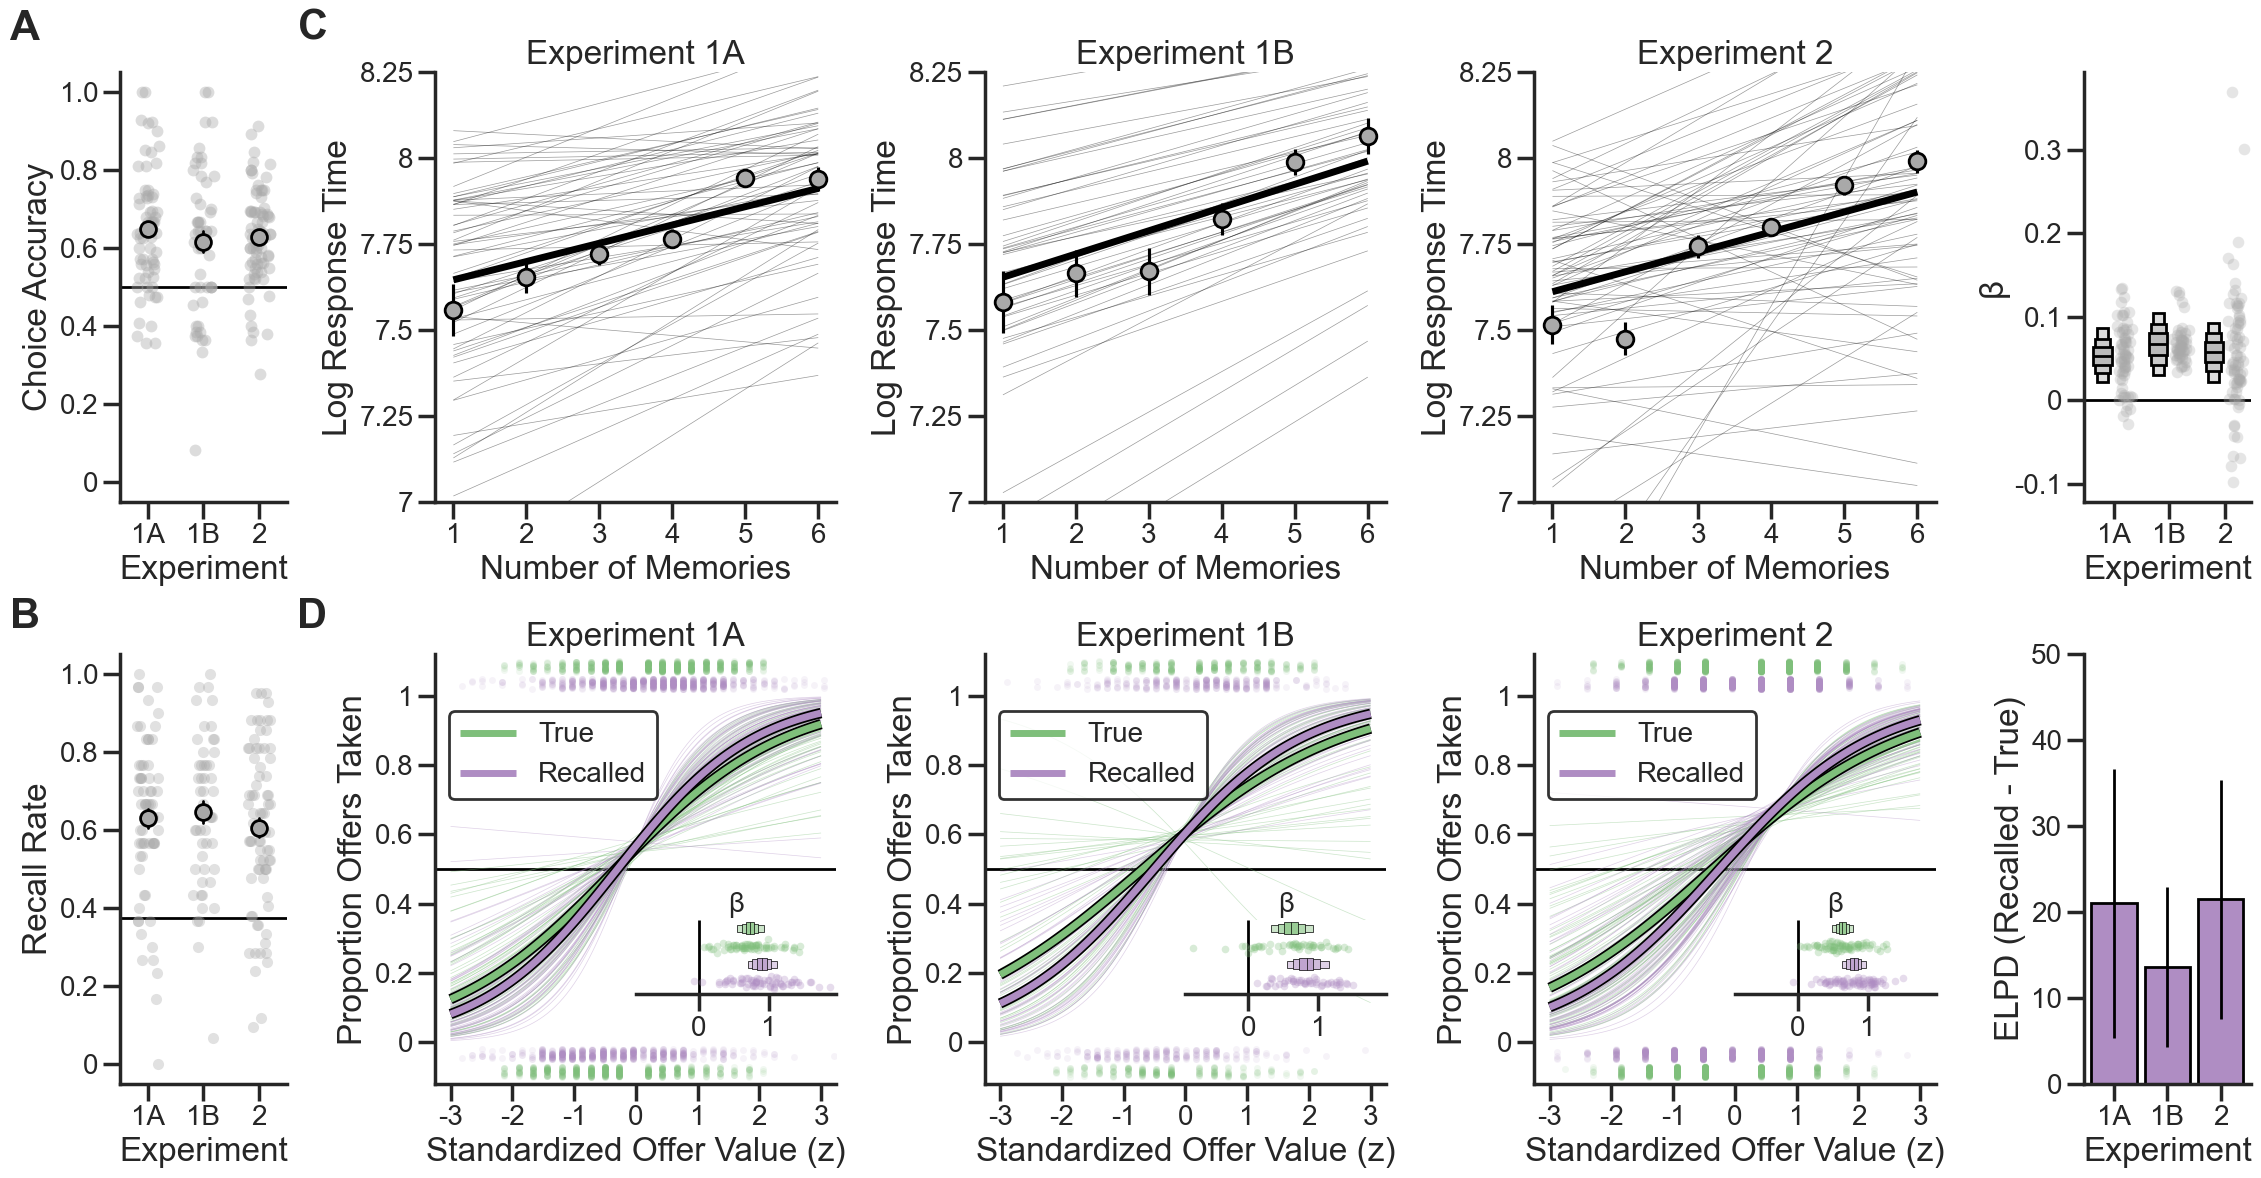

In [ ]:
def plot_choice_effects(true_choice_effects, mem_choice_effects, data, exp_num, main_ax):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    """
    Create figure showing logistic regression effects for true and memory value choice effects.
    """
    # Function to compute logistic curve
    def logistic(x, intercept, slope):
        return 1 / (1 + np.exp(-(intercept + slope * x)))

    # Function to get model parameters
    def get_model_params(df, model_name, intercept_param, slope_param):
        intercept = df.loc[df['parameter'] == intercept_param, 'estimate'].values[0]
        slope = df.loc[df['parameter'] == slope_param, 'estimate'].values[0]
        return intercept, slope

    # Plot individual subject lines for both conditions
    def plot_individual_lines(df, model_name, base_intercept, base_slope, color,
                            intercept_pattern, slope_pattern):
        individual_params = df[df['parameter'].str.startswith('r_wid')]
        slopes = []
        for _, row in individual_params.iterrows():
            if intercept_pattern in row['parameter']:
                subj_id = row['parameter'].split('[')[1].split(',')[0]
                subj_intercept = row['estimate'] + base_intercept
                subj_slope_row = individual_params[
                    individual_params['parameter'].str.contains(f"{subj_id},{slope_pattern}")
                ]
                if not subj_slope_row.empty:
                    subj_slope = subj_slope_row['estimate'].values[0] + base_slope
                    main_ax.plot(x, logistic(x, subj_intercept, subj_slope),
                            color=color, alpha=0.4, linewidth=0.5)
                    slopes.append(subj_slope)
        return slopes

    # Plot uncertainty bands and main lines for both conditions
    def plot_condition(df, model_name, intercept_param, slope_param, color, label):
        # Plot main line
        intercept = df.loc[df['parameter'] == intercept_param, 'estimate'].values[0]
        slope = df.loc[df['parameter'] == slope_param, 'estimate'].values[0]
        main_ax.plot(x, logistic(x, intercept, slope),
                color='k', linewidth=7.5, label='_nolegend_')
        main_ax.plot(x, logistic(x, intercept, slope),
                 color=color, linewidth=5, label=label)
        return slope

    # Function to plot model effects with CIs
    def plot_forest_effect(y_pos, slope, df, param_name, color):
        # Convert hex to RGB
        rgb = int(color[1:], 16)
        base_rgb = ((rgb >> 16) & 255, (rgb >> 8) & 255, rgb & 255)
        base_rgb = tuple(x/255 for x in base_rgb)

        # Function to blend color with white based on alpha
        def blend_with_white(rgb, alpha):
            return tuple(c * alpha + (1 - alpha) for c in rgb)

        # Plot random effects
        if param_name == 'b_value_z':
            slopes = true_indiv_slopes
        else:
            slopes = mem_indiv_slopes
        jitter = np.random.normal(0, 0.1, len(slopes))
        forest_ax.scatter([s for s in slopes], [y_pos + j for j in jitter],
                         color=color, alpha=0.3, s=30, zorder=1, linewidth=0)

        # Plot CIs with decreasing thickness and alpha
        y_offset = 0.75
        for ci_level, height, alpha in zip(['95', '80', '50'], [0.3, 0.4, 0.5], [0.4, 0.6, 0.8]):
            ci_lower = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_lower'].values[0]
            ci_upper = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_upper'].values[0]

            # Calculate solid color equivalent to alpha blending with white
            solid_color = blend_with_white(base_rgb, alpha)

            # Add colored CI rectangle
            forest_ax.add_patch(plt.Rectangle((ci_lower, (y_pos+y_offset) - height/2),
                                            ci_upper - ci_lower, height,
                                            facecolor=solid_color, alpha=1.0, #1.0
                                            edgecolor='black', linewidth=0.5,
                                            zorder=3)) #3

        # Plot main effect as vertical black line
        forest_ax.vlines(x=slope, ymin=(y_pos+y_offset)-0.5/2, ymax=(y_pos+y_offset)+0.5/2,
                        color='black', linewidth=0.5, zorder=4)

    # Generate x values for plotting
    x = np.linspace(-3, 3, 100)

    # Define colors for each condition
    true_color = '#7fbf7b'
    mem_color = '#af8dc3'

    # Get parameters for both models
    true_intercept, true_slope = get_model_params(
        true_choice_effects, 'true', 'b_Intercept', 'b_value_z'
    )
    mem_intercept, mem_slope = get_model_params(
        mem_choice_effects, 'memory', 'b_Intercept', 'b_recalled_mem_value_z'
    )

    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        # Get individual slopes and plot main logistic regression
        true_indiv_slopes = plot_individual_lines(true_choice_effects, 'true', true_intercept, true_slope,
                             true_color, 'Intercept', 'value_z')
        mem_indiv_slopes = plot_individual_lines(mem_choice_effects, 'memory', mem_intercept, mem_slope,
                             mem_color, 'Intercept', 'recalled_mem_value_z')

        true_slope = plot_condition(true_choice_effects, 'true', 'b_Intercept', 'b_value_z',
                      true_color, 'True')
        mem_slope = plot_condition(mem_choice_effects, 'memory', 'b_Intercept', 'b_recalled_mem_value_z',
                      mem_color, 'Recalled')

    # Customize the main plot
    main_ax.set_xlabel('Standardized Offer Value (z)', size=24)
    main_ax.set_ylabel('Proportion Offers Taken', size=24)
    main_ax.plot((-3.25,3.25),(0.5,0.5),'k',zorder=0,linewidth=2)
    main_ax.set_ylim(-0.12, 1.12)
    main_ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    main_ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1],size=20)
    main_ax.set_xlim(-3.25,3.25)
    main_ax.set_xticks([-3,-2,-1,0,1,2,3])
    main_ax.set_xticklabels([-3,-2,-1,0,1,2,3],size=20)
    main_ax.set_title(f"Experiment {exp_num}", size=24)
    leg = main_ax.legend(loc='upper left', bbox_to_anchor=(0.0, 0.9), fontsize=20)
    leg.get_frame().set_edgecolor('black')
    sns.despine(ax=main_ax)

    # Add scatter plots for choices
    # For choices = 1 (top of plot)
    choices_1 = data[data['choice'] == 1]
    # Plot recalled values
    main_ax.scatter(choices_1['recalled_mem_value_z'],
                   np.random.uniform(1.02, 1.05, size=len(choices_1)),
                   color=mem_color, alpha=0.1, s=25, linewidth=0)
    # Plot true values
    main_ax.scatter(choices_1['value_z'],
                   np.random.uniform(1.07, 1.1, size=len(choices_1)),
                   color=true_color, alpha=0.1, s=25, linewidth=0)

    # For choices = 0 (bottom of plot)
    choices_0 = data[data['choice'] == 0]
    # Plot recalled values
    main_ax.scatter(choices_0['recalled_mem_value_z'],
                   np.random.uniform(-0.05, -0.02, size=len(choices_0)),
                   color=mem_color, alpha=0.1, s=25, linewidth=0)
    # Plot true values
    main_ax.scatter(choices_0['value_z'],
                   np.random.uniform(-0.1, -0.07, size=len(choices_0)),
                   color=true_color, alpha=0.1, s=25, linewidth=0)

    # Create inset axes for forest plot
    forest_ax = inset_axes(main_ax,
                          width="100%", height="75%",
                          loc='center',
                          bbox_to_anchor=(0.5, 0.18, 0.5, 0.23),
                          bbox_transform=main_ax.transAxes)

    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        # Plot vertical line at 0
        forest_ax.axvline(x=0, color='k', linestyle='-', alpha=1, zorder=0, linewidth=2)

        # Plot effects for both models
        plot_forest_effect(1, mem_slope, mem_choice_effects, 'b_recalled_mem_value_z', mem_color)
        plot_forest_effect(2.5, true_slope, true_choice_effects, 'b_value_z', true_color)

    # Customize forest plot
    forest_ax.set_ylim(0.5, 3.6)
    forest_ax.set_yticks([])
    forest_ax.set_yticklabels([])
    forest_ax.set_title('β',fontsize=20)

    sns.despine(ax=forest_ax, left=True)

    return forest_ax

def plot_log_rt_effects(rt_effects, data, exp_num, main_ax):
    """
    Create figure showing RT effects for memory condition in log space.
    """
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # Function to get model parameters
    def get_model_params(df, intercept_param, slope_param):
        intercept = df.loc[df['parameter'] == intercept_param, 'estimate'].values[0]
        slope = df.loc[df['parameter'] == slope_param, 'estimate'].values[0]
        return intercept, slope

    # Plot individual subject lines
    def plot_individual_lines(df, base_intercept, base_slope, color):
        individual_params = df[df['parameter'].str.startswith('r_wid')]
        ndt = df.loc[df['parameter'] == 'ndt', 'estimate'].values[0]
        slopes = []
        for _, row in individual_params.iterrows():
            if 'Intercept' in row['parameter']:
                subj_id = row['parameter'].split('[')[1].split(',')[0]
                subj_intercept = row['estimate'] + base_intercept
                subj_slope_row = individual_params[
                    individual_params['parameter'].str.contains(f"{subj_id},n_total_memories_shown")
                ]
                if not subj_slope_row.empty:
                    subj_slope = subj_slope_row['estimate'].values[0] + base_slope
                    y_vals = subj_intercept + subj_slope * x
                    main_ax.plot(x, y_vals, color='k', alpha=0.4, linewidth=0.5)
                    slopes.append(subj_slope)
        return slopes

    # Plot main line
    def plot_condition(df, intercept_param, slope_param, color, label):
        intercept = df.loc[df['parameter'] == intercept_param, 'estimate'].values[0]
        slope = df.loc[df['parameter'] == slope_param, 'estimate'].values[0]
        y_vals = intercept + slope * x
        main_ax.plot(x, y_vals, color='k', linewidth=5, label=label)
        return slope

    # Generate x values for plotting
    x = np.linspace(1, 6, 6)  # Adjusted range for number of memories

    # Define color for memory condition
    mem_color = '#A9A9A9'

    # Get parameters for the model
    mem_intercept, mem_slope = get_model_params(
        rt_effects, 'b_Intercept', 'b_n_total_memories_shown'
    )

    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        # Get individual slopes and plot main regression
        slopes = plot_individual_lines(rt_effects, mem_intercept, mem_slope, mem_color)
        main_slope = plot_condition(rt_effects, 'b_Intercept', 'b_n_total_memories_shown',
                                  mem_color, 'RT')

        # Plot the data
        d = data.dropna()
        bin_means, bin_edges, _ = stats.binned_statistic(d['n_total_memories'],
                                                      np.log(d['rt']),
                                                      statistic='mean', bins=10000)
        bin_width = (bin_edges[1] - bin_edges[0])
        bin_centers = np.round(bin_edges[1:] - bin_width / 2)

        # Standard error for error bars
        bin_std, _, _ = stats.binned_statistic(d['n_total_memories'],
                                             np.log(d['rt']),
                                             statistic=stats.sem, bins=10000)
        # Get lower and upper error bar edges
        bin_lower = bin_means - bin_std
        bin_upper = bin_means + bin_std

        # Adding error bars with matplotlib
        main_ax.errorbar(bin_centers, bin_means,
                        yerr=[bin_means - bin_lower, bin_upper - bin_means],
                        fmt='o', mec='black', mew=2,
                        color=mem_color, ecolor='black', elinewidth=2.25,
                        capsize=0, zorder=200)

    # Customize the main plot
    main_ax.set_xlabel('Number of Memories', size=24)
    main_ax.set_ylabel('Log Response Time', size=24)
    main_ax.set_title(f"Experiment {exp_num}", size=24)
    main_ax.set_xlim(0.75, 6.25)
    main_ax.set_xticks([1,2,3,4,5,6])
    main_ax.set_xticklabels([1,2,3,4,5,6], size=20)
    main_ax.set_ylim(7, 8.25)  # Adjusted for log scale
    main_ax.set_yticks([7, 7.25, 7.5, 7.75, 8, 8.25])
    main_ax.set_yticklabels([7, 7.25, 7.5, 7.75, 8, 8.25], size=20)

    sns.despine(ax=main_ax)

def plot_forest_effect(y_pos, slope, df, param_name, color, ax):
    rgb = int(color[1:], 16)
    base_rgb = ((rgb >> 16) & 255, (rgb >> 8) & 255, rgb & 255)
    base_rgb = tuple(x/255 for x in base_rgb)

    def blend_with_white(rgb, alpha):
        return tuple(c * alpha + (1 - alpha) for c in rgb)

    # Get individual slopes
    individual_params = df[df['parameter'].str.startswith('r_wid')]
    slopes = []
    for _, row in individual_params.iterrows():
        if 'Intercept' in row['parameter']:
            subj_id = row['parameter'].split('[')[1].split(',')[0]
            slope_row = individual_params[
                individual_params['parameter'].str.contains(f"{subj_id},n_total_memories_shown")
            ]
            if not slope_row.empty:
                slopes.append(slope_row['estimate'].values[0] + slope)

    x_offset = 0.4
    point_pos = y_pos + x_offset + 0.2
    jitter = np.random.normal(0, 0.1, len(slopes))
    ax.scatter([point_pos + j for j in jitter], [s for s in slopes],
               color=color, alpha=0.3, s=70, zorder=1, linewidth=0)

    # Plot CIs with decreasing thickness and alpha
    for ci_level, width, alpha in zip(['95', '80', '50'], [0.3, 0.4, 0.5], [0.4, 0.6, 0.8]):
        ci_lower = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_lower'].values[0]
        ci_upper = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_upper'].values[0]

        solid_color = blend_with_white(base_rgb, alpha)

        ax.add_patch(plt.Rectangle((y_pos - width/2, ci_lower),
                                 width, ci_upper - ci_lower,
                                 facecolor=solid_color, alpha=1.0,
                                 edgecolor='black', linewidth=2,
                                 zorder=3))

    # Plot main effect line
    ax.hlines(y=slope, xmin=y_pos-0.5/2, xmax=y_pos+0.5/2,
             color='black', linewidth=2, zorder=4)

    return (y_pos + point_pos) / 2

# Create the overall figure
fig = plt.figure(figsize=(23, 12))

gs = plt.GridSpec(2, 5, width_ratios=[2.5, 6, 6, 6, 2.5])
ax_acc = fig.add_subplot(gs[0,0])
ax_mem = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[0,1])
ax6 = fig.add_subplot(gs[0,2])
ax7 = fig.add_subplot(gs[0,3])
ax8 = fig.add_subplot(gs[0,4])
ax1 = fig.add_subplot(gs[1,1])
ax2 = fig.add_subplot(gs[1,2])
ax3 = fig.add_subplot(gs[1,3])
ax4 = fig.add_subplot(gs[1,4])

# Create the plots
forest_ax1 = plot_choice_effects(true_choice_effects_1a, mem_choice_effects_1a, data_1a, "1A", ax1)
forest_ax2 = plot_choice_effects(true_choice_effects_1b, mem_choice_effects_1b, data_1b, "1B", ax2)
forest_ax3 = plot_choice_effects(true_choice_effects_2, mem_choice_effects_2, data_2, "2", ax3)
# Get the global min/max for x-axis limits across all forest plots
x_min = min(forest_ax1.get_xlim()[0], forest_ax2.get_xlim()[0],forest_ax3.get_xlim()[0])
x_max = max(forest_ax1.get_xlim()[1],forest_ax2.get_xlim()[1], forest_ax3.get_xlim()[1])
for ax in [forest_ax1, forest_ax2, forest_ax3]:
    # Make x-axes consistent for all forest plots
    ax.set_xlim(x_min, x_max)
    ax.locator_params(axis='x', nbins=3)
    ax.tick_params(axis='x', labelsize=20)

elpd_diffs = [elpd_1a, elpd_1b, elpd_2]
color = '#af8dc3'
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
    for i, samp in enumerate(["1A", "1B", "2"]):
        edf = elpd_diffs[i]
        ax4.bar(i, edf.elpd_diff, color=color, linewidth=2, edgecolor="0", width=0.85)
        ax4.plot((i,i), (edf.elpd_diff+edf.se_diff, edf.elpd_diff-edf.se_diff),
                 linewidth=2, color='k')

#ax4.plot((-0.5,1.5), (0,0), 'k', linewidth=2)
ax4.set_ylabel("ELPD (Recalled - True)", fontsize=24)
ax4.set_xlabel("")
ax4.tick_params(axis='y', which='major', labelsize=20)
ax4.set_xticks([0,1,2])
ax4.set_ylim([0,50])
ax4.set_xticklabels(["1A", "1B", "2"], fontsize=20)
ax4.set_xlabel("Experiment", fontsize=24)
sns.despine(ax=ax4)

# Move on to the second row, RT effects now
plot_log_rt_effects(rt_effects_1a[rt_effects_1a.model == "memory"], data_1a_full, "1A", ax5)
plot_log_rt_effects(rt_effects_1b[rt_effects_1b.model == "memory"], data_1b_full, "1B", ax6)
plot_log_rt_effects(rt_effects_2[rt_effects_2.model == "memory"], data_2_full, "2", ax7)
ax = ax8
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
    # Plot horizontal line at 0
    ax.axhline(y=0, color='k', linestyle='-', alpha=1, zorder=0, linewidth=2)

    mem_color = '#A9A9A9'
    xtick_positions = []

    # Dataset 1A
    rt_effects = rt_effects_1a[rt_effects_1a.model == "memory"]
    main_slope = rt_effects.loc[rt_effects['parameter'] == "b_n_total_memories_shown", 'estimate'].values[0]
    xtick_positions.append(plot_forest_effect(0.5, main_slope, rt_effects, 'b_n_total_memories_shown', mem_color, ax))

    # Dataset 1B - reduced spacing
    rt_effects = rt_effects_1b[rt_effects_1b.model == "memory"]
    main_slope = rt_effects.loc[rt_effects['parameter'] == "b_n_total_memories_shown", 'estimate'].values[0]
    xtick_positions.append(plot_forest_effect(2, main_slope, rt_effects, 'b_n_total_memories_shown', mem_color, ax))

    # Dataset 2 - reduced spacing
    rt_effects = rt_effects_2[rt_effects_2.model == "memory"]
    main_slope = rt_effects.loc[rt_effects['parameter'] == "b_n_total_memories_shown", 'estimate'].values[0]
    xtick_positions.append(plot_forest_effect(3.5, main_slope, rt_effects, 'b_n_total_memories_shown', mem_color, ax))

    # Set x-axis ticks and labels at the middle positions
    ax.set_xticks(xtick_positions)
    ax.set_xticklabels(['1A', '1B', '2'], fontsize=20)
    ax.set_xlabel("Experiment", fontsize=24)
    ax.set_xlim(0, 4.5)
    ax.set_ylabel('β', fontsize=24)
    ax.set_yticks([-0.1, 0, 0.1, 0.2, 0.3])
    ax.set_yticklabels([-0.1, 0, 0.1, 0.2, 0.3], fontsize=20)

    sns.despine(ax=ax)
    
# Plot the choice accuracy
ax = ax_acc
data_1a['Experiment'] = '1A'
data_1b['Experiment'] = '1B'
data_2['Experiment'] = '2'
choice_v1 = pd.concat([data_1a, data_1b, data_2])
choice_v1 = choice_v1.groupby(['wid', 'Experiment'])['correct'].mean().reset_index(name="correct")
# Calculate mean and SEM manually for first plot
means1 = choice_v1.groupby('Experiment')['correct'].mean()
sems1 = choice_v1.groupby('Experiment')['correct'].sem()
# Strip plot for first plot
sns.stripplot(x="Experiment", y="correct", data=choice_v1,jitter=0.2,
              ax=ax, alpha=0.4, size=8.5, linewidth=0,color='#A9A9A9')
# Manual error bars and points (black edges, filled center)
for i, (mean, sem) in enumerate(zip(means1, sems1)):
    # Error bars
    ax.plot([i, i], [mean-sem, mean+sem], color='k', linewidth=2, zorder=3)
    # Point with black edge, gray fill
    ax.scatter([i], [mean], s=130, color='#A9A9A9',
                edgecolor='k', linewidth=2, zorder=4)
# Chance line
ax.plot((-0.5, 2.5), (0.5, 0.5), 'k', linewidth=2, zorder=0)
# Customize both plots
ax.set_xlabel('Experiment', size=24)
ax.set_ylabel('Choice Accuracy', size=24)
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.5, 2.5)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], size=20)
ax.set_xticklabels(ax.get_xticklabels(), size=20)
sns.despine(ax=ax)

# Plot the recall accuracy
ax = ax_mem
recall_v1 = pd.concat([recall_1a, recall_1b, recall_2])
# Calculate mean and SEM manually for first plot
means1 = recall_v1.groupby('Experiment')['recall_rate'].mean()
sems1 = recall_v1.groupby('Experiment')['recall_rate'].sem()
# Strip plot for first plot
sns.stripplot(x="Experiment", y="recall_rate", data=recall_v1,jitter=0.2,
              ax=ax, alpha=0.35, size=8, linewidth=0,color='#A9A9A9')
# Manual error bars and points (black edges, filled center)
for i, (mean, sem) in enumerate(zip(means1, sems1)):
    # Error bars
    ax.plot([i, i], [mean-sem, mean+sem], color='k', linewidth=2, zorder=3)
    # Point with black edge, gray fill
    ax.scatter([i], [mean], s=130, color='#A9A9A9',
                edgecolor='k', linewidth=2, zorder=4)
# Chance line
ax.plot((-0.5, 2.5), (6/16, 6/16), 'k', linewidth=2, zorder=0)
# Customize both plots
ax.set_xlabel('Experiment', size=24)
ax.set_ylabel('Recall Rate', size=24)
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.5, 2.5)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], size=20)
ax.set_xticklabels(ax.get_xticklabels(), size=20)

sns.despine(ax=ax)

fig.text(0.01, 0.97, 'A', fontsize=30, fontweight='bold')
fig.text(0.01, 0.48, 'B', fontsize=30, fontweight='bold')
fig.text(0.135, 0.97, 'C', fontsize=30, fontweight='bold')
fig.text(0.135, 0.48, 'D', fontsize=30, fontweight='bold')

plt.tight_layout()
plt.savefig("figures/Figure2.pdf")

# Figure 3: Experiments 3A and 3B

In [5]:
data_3a = pd.read_csv(curr_wd + "/data/choiceDataMemValue_3A.csv")
before_3a = data_3a[data_3a.multi_time == "Before"].reset_index(drop=True)
before_3a["value_z"] = zscore(before_3a["value"])
before_3a["recalled_mem_value_z"] = zscore(before_3a["recalled_mem_value"])
before_3a = before_3a.dropna()
after_3a = data_3a[data_3a.multi_time == "After"].reset_index(drop=True)
after_3a["value_z"] = zscore(after_3a["value"])
after_3a["recalled_mem_value_z"] = zscore(after_3a["recalled_mem_value"])
after_3a = after_3a.dropna()
data_3a_full = pd.read_csv(curr_wd + "/data/choiceDataFull_3A.csv")
before_3a_full = data_3a_full[data_3a_full.multi_time == "Before"].reset_index(drop=True)
after_3a_full = data_3a_full[data_3a_full.multi_time == "After"].reset_index(drop=True)
choice_effects_3a = pd.read_csv(curr_wd + "/output/choice_effects_3A.csv")
before_true_choice_effects_3a = choice_effects_3a[choice_effects_3a.model == "before_true"]
before_mem_choice_effects_3a = choice_effects_3a[choice_effects_3a.model == "before_memory"]
after_true_choice_effects_3a = choice_effects_3a[choice_effects_3a.model == "after_true"]
after_mem_choice_effects_3a = choice_effects_3a[choice_effects_3a.model == "after_memory"]
elpd_3a = pd.read_csv(curr_wd + "/output/choice_elpd_diff_3A.csv")
rt_effects_3a = pd.read_csv(curr_wd + "/output/rt_effects_3A.csv")

# Data Experiment 3B
data_3b = pd.read_csv(curr_wd + "/data/choiceDataMemValue_3B.csv")
before_3b = data_3b[data_3b.multi_time == "Before"].reset_index(drop=True)
before_3b["value_z"] = zscore(before_3b["value"])
before_3b["recalled_mem_value_z"] = zscore(before_3b["recalled_mem_value"])
before_3b = before_3b.dropna()
after_3b = data_3b[data_3b.multi_time == "After"].reset_index(drop=True)
after_3b["value_z"] = zscore(after_3b["value"])
after_3b["recalled_mem_value_z"] = zscore(after_3b["recalled_mem_value"])
after_3b = after_3b.dropna()
data_3b_full = pd.read_csv(curr_wd + "/data/choiceDataFull_3B.csv")
before_3b_full = data_3b_full[data_3b_full.multi_time == "Before"].reset_index(drop=True)
after_3b_full = data_3b_full[data_3b_full.multi_time == "After"].reset_index(drop=True)
choice_effects_3b = pd.read_csv(curr_wd + "/output/choice_effects_3B.csv")
before_true_choice_effects_3b = choice_effects_3b[choice_effects_3b.model == "before_true"]
before_mem_choice_effects_3b = choice_effects_3b[choice_effects_3b.model == "before_memory"]
after_true_choice_effects_3b = choice_effects_3b[choice_effects_3b.model == "after_true"]
after_mem_choice_effects_3b = choice_effects_3b[choice_effects_3b.model == "after_memory"]
elpd_3b = pd.read_csv(curr_wd + "/output/choice_elpd_diff_3B.csv")
rt_effects_3b = pd.read_csv(curr_wd + "/output/rt_effects_3B.csv")


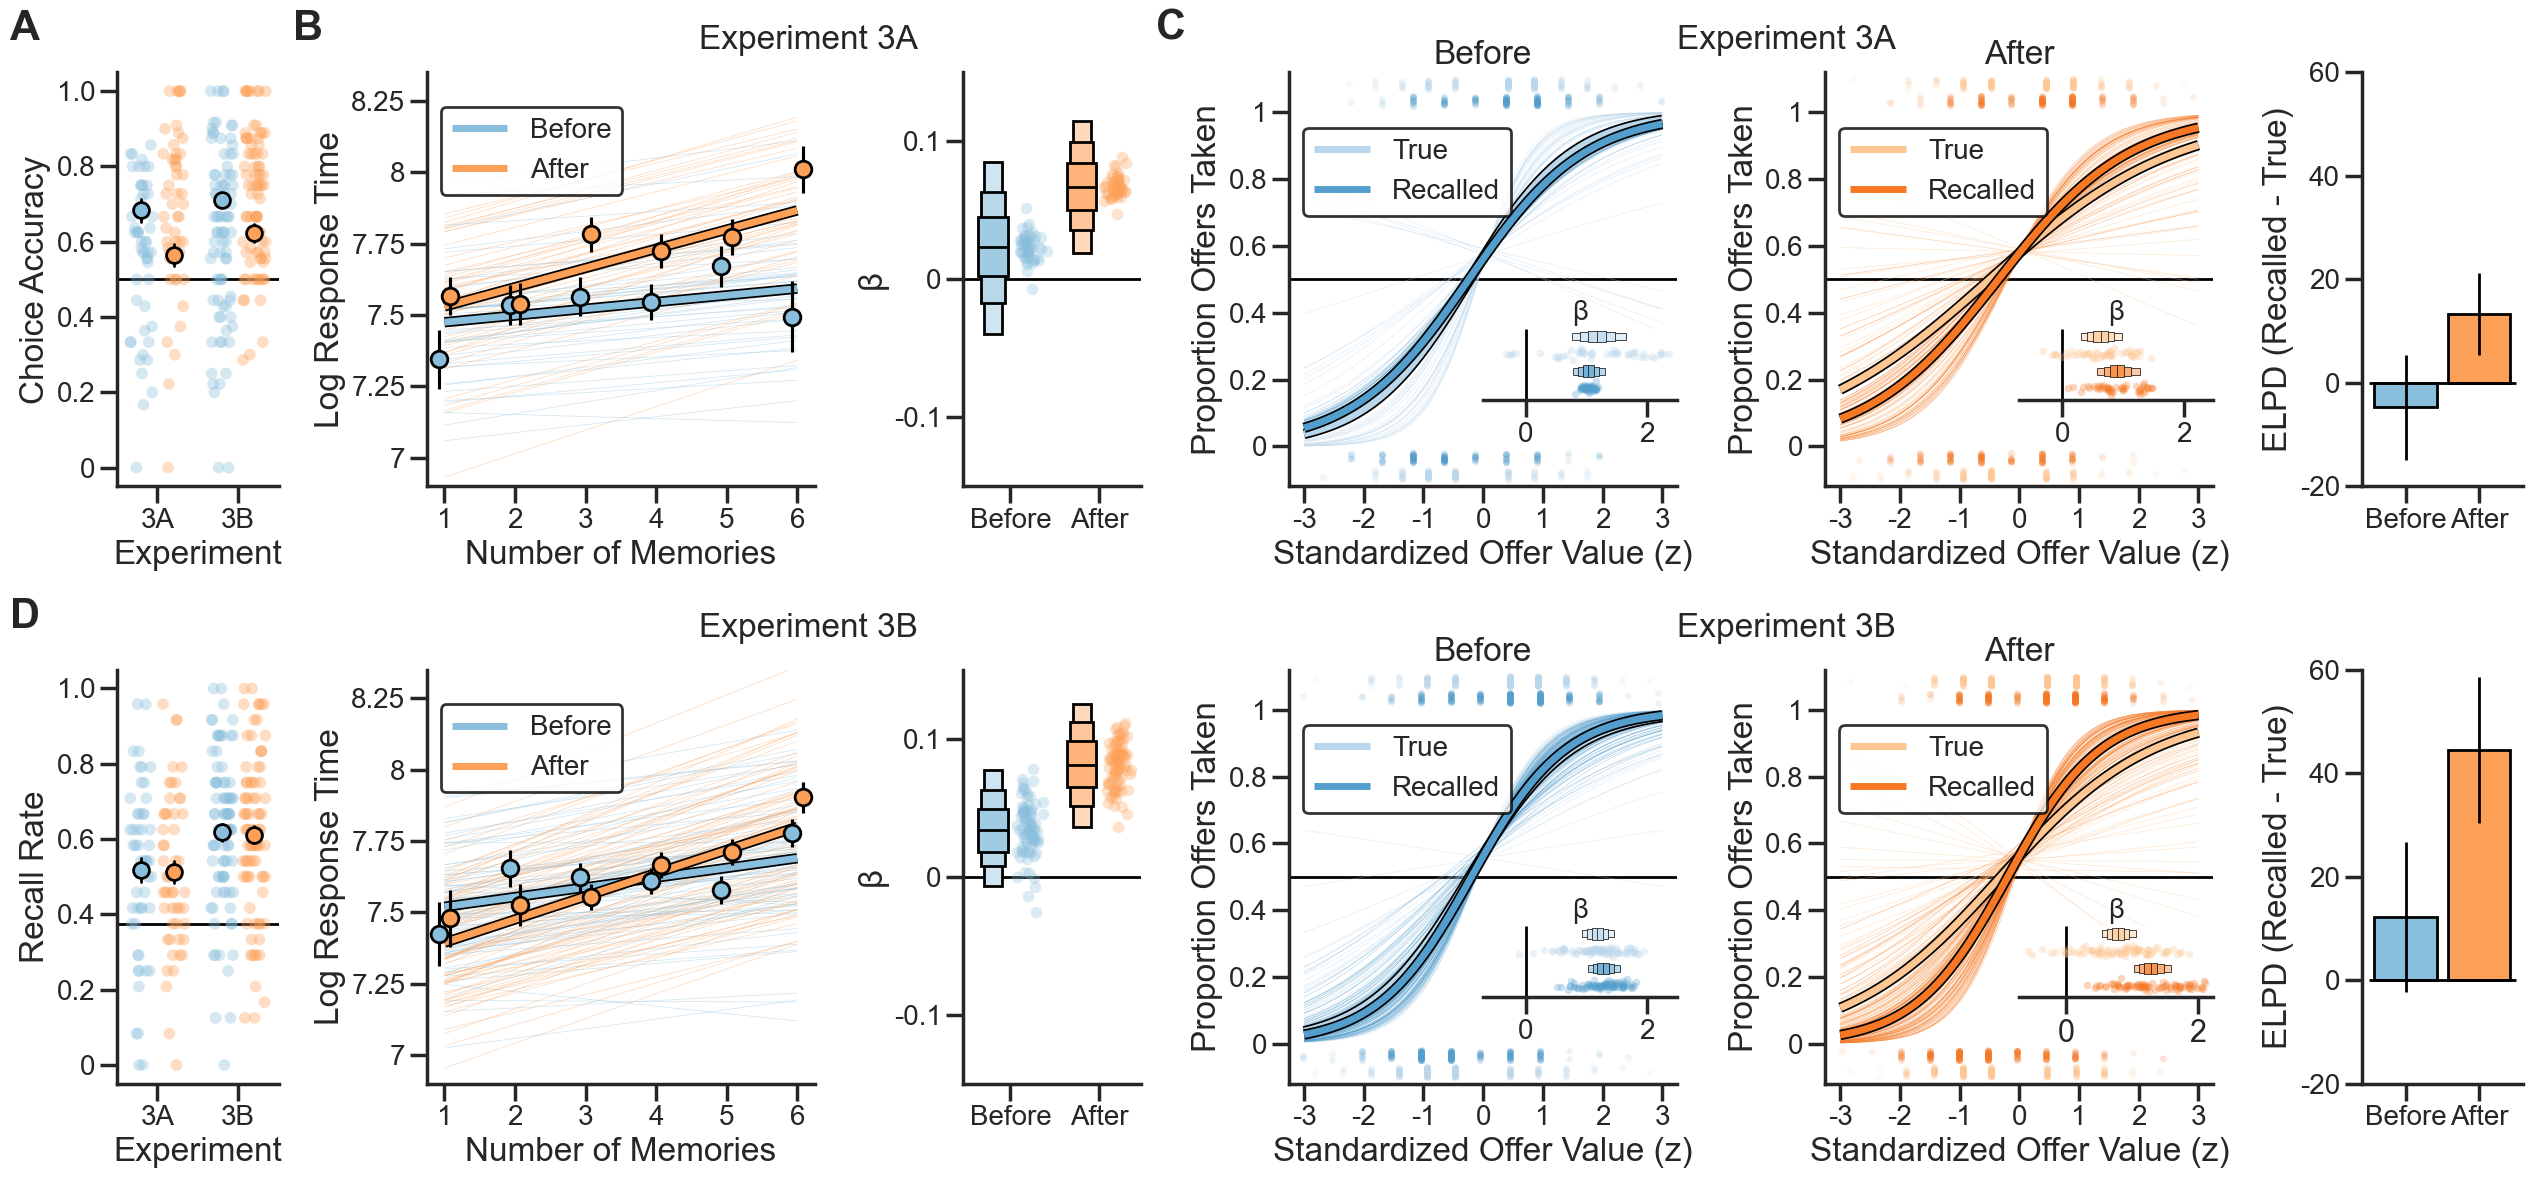

In [144]:
def plot_choice_effects(true_choice_effects, mem_choice_effects, data, exp_num, main_ax, palette):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    """
    Create figure showing logistic regression effects for true and memory value choice effects.
    """
    # Function to compute logistic curve
    def logistic(x, intercept, slope):
        return 1 / (1 + np.exp(-(intercept + slope * x)))

    # Function to get model parameters
    def get_model_params(df, model_name, intercept_param, slope_param):
        intercept = df.loc[df['parameter'] == intercept_param, 'estimate'].values[0]
        slope = df.loc[df['parameter'] == slope_param, 'estimate'].values[0]
        return intercept, slope

    # Plot individual subject lines for both conditions
    def plot_individual_lines(df, model_name, base_intercept, base_slope, color,
                            intercept_pattern, slope_pattern):
        individual_params = df[df['parameter'].str.startswith('r_wid')]
        slopes = []
        for _, row in individual_params.iterrows():
            if intercept_pattern in row['parameter']:
                subj_id = row['parameter'].split('[')[1].split(',')[0]
                subj_intercept = row['estimate'] + base_intercept
                subj_slope_row = individual_params[
                    individual_params['parameter'].str.contains(f"{subj_id},{slope_pattern}")
                ]
                if not subj_slope_row.empty:
                    subj_slope = subj_slope_row['estimate'].values[0] + base_slope
                    main_ax.plot(x, logistic(x, subj_intercept, subj_slope),
                            color=color, alpha=0.4, linewidth=0.5) #0.3, 0.2
                    slopes.append(subj_slope)
        return slopes

    # Plot uncertainty bands and main lines for both conditions
    def plot_condition(df, model_name, intercept_param, slope_param, color, label):
        # Plot main line
        intercept = df.loc[df['parameter'] == intercept_param, 'estimate'].values[0]
        slope = df.loc[df['parameter'] == slope_param, 'estimate'].values[0]
        main_ax.plot(x, logistic(x, intercept, slope),
                color='k', linewidth=7.5, label='_nolegend_')
        main_ax.plot(x, logistic(x, intercept, slope),
                 color=color, linewidth=5, label=label)
        return slope

    # Function to plot model effects with CIs
    def plot_forest_effect(y_pos, slope, df, param_name, color):
        # Convert hex to RGB
        rgb = int(color[1:], 16)
        base_rgb = ((rgb >> 16) & 255, (rgb >> 8) & 255, rgb & 255)
        base_rgb = tuple(x/255 for x in base_rgb)

        # Function to blend color with white based on alpha
        def blend_with_white(rgb, alpha):
            return tuple(c * alpha + (1 - alpha) for c in rgb)

        # Plot random effects
        if param_name == 'b_value_z':
            slopes = true_indiv_slopes
        else:
            slopes = mem_indiv_slopes
        jitter = np.random.normal(0, 0.1, len(slopes))
        forest_ax.scatter([s for s in slopes], [y_pos + j for j in jitter],
                         color=color, alpha=0.3, s=30, zorder=1, linewidth=0)

        # Plot CIs with decreasing thickness and alpha
        y_offset = 0.75
        for ci_level, height, alpha in zip(['95', '80', '50'], [0.3, 0.4, 0.5], [0.4, 0.6, 0.8]):
            ci_lower = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_lower'].values[0]
            ci_upper = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_upper'].values[0]

            # Calculate solid color equivalent to alpha blending with white
            solid_color = blend_with_white(base_rgb, alpha)

            # Add colored CI rectangle
            forest_ax.add_patch(plt.Rectangle((ci_lower, (y_pos+y_offset) - height/2),
                                            ci_upper - ci_lower, height,
                                            facecolor=solid_color, alpha=1.0, #1.0
                                            edgecolor='black', linewidth=0.5,
                                            zorder=3)) #3

        # Plot main effect as vertical black line
        forest_ax.vlines(x=slope, ymin=(y_pos+y_offset)-0.5/2, ymax=(y_pos+y_offset)+0.5/2,
                        color='black', linewidth=0.5, zorder=4)

    # Generate x values for plotting
    x = np.linspace(-3, 3, 100)

    # Define colors for each condition
    true_color = palette[0]
    mem_color = palette[1]

    # Get parameters for both models
    true_intercept, true_slope = get_model_params(
        true_choice_effects, 'true', 'b_Intercept', 'b_value_z'
    )
    mem_intercept, mem_slope = get_model_params(
        mem_choice_effects, 'memory', 'b_Intercept', 'b_recalled_mem_value_z'
    )

    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        # Get individual slopes and plot main logistic regression
        true_indiv_slopes = plot_individual_lines(true_choice_effects, 'true', true_intercept, true_slope,
                             true_color, 'Intercept', 'value_z')
        mem_indiv_slopes = plot_individual_lines(mem_choice_effects, 'memory', mem_intercept, mem_slope,
                             mem_color, 'Intercept', 'recalled_mem_value_z')

        true_slope = plot_condition(true_choice_effects, 'true', 'b_Intercept', 'b_value_z',
                      true_color, 'True')
        mem_slope = plot_condition(mem_choice_effects, 'memory', 'b_Intercept', 'b_recalled_mem_value_z',
                      mem_color, 'Recalled')

    # Customize the main plot
    main_ax.set_xlabel('Standardized Offer Value (z)', size=24)
    main_ax.set_ylabel('Proportion Offers Taken', size=24)
    main_ax.plot((-3.25,3.25),(0.5,0.5),'k',zorder=0,linewidth=2)
    main_ax.set_ylim(-0.12, 1.12)
    main_ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    main_ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1],size=20)
    main_ax.set_xlim(-3.25,3.25)
    main_ax.set_xticks([-3,-2,-1,0,1,2,3])
    main_ax.set_xticklabels([-3,-2,-1,0,1,2,3],size=20)
    main_ax.set_title(f"{exp_num}", size=24)
    leg = main_ax.legend(loc='upper left', bbox_to_anchor=(0.0, 0.9), fontsize=20)
    leg.get_frame().set_edgecolor('black')
    sns.despine(ax=main_ax)

    # Add scatter plots for choices
    # For choices = 1 (top of plot)
    choices_1 = data[data['choice'] == 1]
    # Plot recalled values
    main_ax.scatter(choices_1['recalled_mem_value_z'],
                   np.random.uniform(1.02, 1.05, size=len(choices_1)),
                   color=mem_color, alpha=0.1, s=25, linewidth=0)
    # Plot true values
    main_ax.scatter(choices_1['value_z'],
                   np.random.uniform(1.07, 1.1, size=len(choices_1)),
                   color=true_color, alpha=0.1, s=25, linewidth=0)

    # For choices = 0 (bottom of plot)
    choices_0 = data[data['choice'] == 0]
    # Plot recalled values
    main_ax.scatter(choices_0['recalled_mem_value_z'],
                   np.random.uniform(-0.05, -0.02, size=len(choices_0)),
                   color=mem_color, alpha=0.1, s=25, linewidth=0)
    # Plot true values
    main_ax.scatter(choices_0['value_z'],
                   np.random.uniform(-0.1, -0.07, size=len(choices_0)),
                   color=true_color, alpha=0.1, s=25, linewidth=0)

    # Create inset axes for forest plot
    forest_ax = inset_axes(main_ax,
                          width="100%", height="75%",
                          loc='center',
                          bbox_to_anchor=(0.5, 0.18, 0.5, 0.23),
                          bbox_transform=main_ax.transAxes)

    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        # Plot vertical line at 0
        forest_ax.axvline(x=0, color='k', linestyle='-', alpha=1, zorder=0, linewidth=2)

        # Plot effects for both models
        plot_forest_effect(1, mem_slope, mem_choice_effects, 'b_recalled_mem_value_z', mem_color)
        plot_forest_effect(2.5, true_slope, true_choice_effects, 'b_value_z', true_color)

    # Customize forest plot
    forest_ax.set_ylim(0.5, 3.6) #2.5
    forest_ax.set_yticks([])
    forest_ax.set_yticklabels([])
    forest_ax.set_title('β',fontsize=20)

    sns.despine(ax=forest_ax, left=True)

    return forest_ax

def plot_log_rt_effects(rt_effects, data, exp_num, main_ax, color, offset, label):
    """
    Create figure showing RT effects for memory condition in log space.
    """
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # Function to get model parameters
    def get_model_params(df, intercept_param, slope_param):
        intercept = df.loc[df['parameter'] == intercept_param, 'estimate'].values[0]
        slope = df.loc[df['parameter'] == slope_param, 'estimate'].values[0]
        return intercept, slope

    # Plot individual subject lines
    def plot_individual_lines(df, base_intercept, base_slope, color):
        individual_params = df[df['parameter'].str.startswith('r_wid')]
        ndt = df.loc[df['parameter'] == 'ndt', 'estimate'].values[0]
        slopes = []
        for _, row in individual_params.iterrows():
            if 'Intercept' in row['parameter']:
                subj_id = row['parameter'].split('[')[1].split(',')[0]
                subj_intercept = row['estimate'] + base_intercept
                subj_slope_row = individual_params[
                    individual_params['parameter'].str.contains(f"{subj_id},n_total_memories_shown")
                ]
                if not subj_slope_row.empty:
                    subj_slope = subj_slope_row['estimate'].values[0] + base_slope
                    y_vals = subj_intercept + subj_slope * x
                    main_ax.plot(x, y_vals, color=color, alpha=0.4, linewidth=0.5, zorder=0)
                    slopes.append(subj_slope)
        return slopes

    # Plot main line
    def plot_condition(df, intercept_param, slope_param, color, label):
        intercept = df.loc[df['parameter'] == intercept_param, 'estimate'].values[0]
        slope = df.loc[df['parameter'] == slope_param, 'estimate'].values[0]
        y_vals = intercept + slope * x
        # Plot the black edge first (slightly thicker)
        main_ax.plot(x, y_vals, color='black', linewidth=7.5, label='_nolegend_')  
        # Plot the colored line on top (slightly thinner)
        main_ax.plot(x, y_vals, color=color, linewidth=5, label=label)
        return slope

    # Generate x values for plotting
    x = np.linspace(1, 6, 6)

    # Define color for memory condition
    mem_color = color

    # Get parameters for the model
    mem_intercept, mem_slope = get_model_params(
        rt_effects, 'b_Intercept', 'b_n_total_memories_shown'
    )

    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        # Get individual slopes and plot main regression
        slopes = plot_individual_lines(rt_effects, mem_intercept, mem_slope, mem_color)
        main_slope = plot_condition(rt_effects, 'b_Intercept', 'b_n_total_memories_shown',
                                  mem_color, label)

        # Plot the data
        d = data.dropna()
        # Create bins specifically for values 1-6
        memory_values = np.arange(1, 7)
        bin_means = []
        bin_stds = []

        # Calculate mean and std for each discrete value
        for val in memory_values:
            val_data = np.log(d[d['n_total_memories'] == val]['rt'])
            val_data = val_data[~np.isinf(val_data)]
            if len(val_data) > 0:  # Check if we have data for this value
                bin_means.append(np.mean(val_data))
                bin_stds.append(stats.sem(val_data))
            else:
                bin_means.append(np.nan)
                bin_stds.append(np.nan)

        bin_means = np.array(bin_means)
        bin_stds = np.array(bin_stds)

        # Get lower and upper error bar edges
        bin_lower = bin_means - bin_stds
        bin_upper = bin_means + bin_stds

        # Apply offset to x-values
        bin_centers = memory_values + offset

        # Adding error bars with matplotlib
        main_ax.errorbar(bin_centers, bin_means,
                        yerr=[bin_means - bin_lower, bin_upper - bin_means],
                        fmt='o', mec='black', mew=2,
                        color=mem_color, ecolor='black', elinewidth=2.25,
                        capsize=0, zorder=200)

    # Customize the main plot
    main_ax.set_xlabel('Number of Memories', size=24)
    main_ax.set_ylabel('Log Response Time', size=24)
    main_ax.set_xlim(0.75, 6.25)
    main_ax.set_xticks([1,2,3,4,5,6])
    main_ax.set_xticklabels([1,2,3,4,5,6], size=20)
    main_ax.set_ylim(6.9, 8.35)  # Adjusted for log scale
    main_ax.set_yticks([7, 7.25, 7.5, 7.75, 8, 8.25])
    main_ax.set_yticklabels([7, 7.25, 7.5, 7.75, 8, 8.25], size=20)
    leg = main_ax.legend(loc='upper left', bbox_to_anchor=(0.0, 0.95), fontsize=20)
    leg.get_frame().set_edgecolor('black')
    sns.despine(ax=main_ax)

def plot_forest_effect(y_pos, slope, df, param_name, color, ax):
    rgb = int(color[1:], 16)
    base_rgb = ((rgb >> 16) & 255, (rgb >> 8) & 255, rgb & 255)
    base_rgb = tuple(x/255 for x in base_rgb)

    def blend_with_white(rgb, alpha):
        return tuple(c * alpha + (1 - alpha) for c in rgb)

    # Get individual slopes
    individual_params = df[df['parameter'].str.startswith('r_wid')]
    slopes = []
    for _, row in individual_params.iterrows():
        if 'Intercept' in row['parameter']:
            subj_id = row['parameter'].split('[')[1].split(',')[0]
            slope_row = individual_params[
                individual_params['parameter'].str.contains(f"{subj_id},n_total_memories_shown")
            ]
            if not slope_row.empty:
                slopes.append(slope_row['estimate'].values[0] + slope)

    x_offset = 0.4
    point_pos = y_pos + x_offset + 0.2  # Store point position
    jitter = np.random.normal(0, 0.1, len(slopes))
    ax.scatter([point_pos + j for j in jitter], [s for s in slopes],
               color=color, alpha=0.3, s=70, zorder=1, linewidth=0)  # Increased s from 30 to 50

    # Plot CIs with decreasing thickness and alpha
    for ci_level, width, alpha in zip(['95', '80', '50'], [0.3, 0.4, 0.5], [0.4, 0.6, 0.8]):
        ci_lower = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_lower'].values[0]
        ci_upper = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_upper'].values[0]

        solid_color = blend_with_white(base_rgb, alpha)

        ax.add_patch(plt.Rectangle((y_pos - width/2, ci_lower),
                                 width, ci_upper - ci_lower,
                                 facecolor=solid_color, alpha=1.0,
                                 edgecolor='black', linewidth=2,
                                 zorder=3))

    # Plot main effect line
    ax.hlines(y=slope, xmin=y_pos-0.5/2, xmax=y_pos+0.5/2,
             color='black', linewidth=2, zorder=4)

    return (y_pos + point_pos) / 2  # Return position for xtick

# Create the overall figure
fig = plt.figure(figsize=(25.75, 12))

# Create subplot grid with different column widths
gs = plt.GridSpec(2, 6, width_ratios=[2.5, 6, 2.75, 6, 6, 2.5])

# Create subplot axes
ax_acc = fig.add_subplot(gs[0,0])
ax_mem = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[0,1])
ax9 = fig.add_subplot(gs[0,2])
ax1 = fig.add_subplot(gs[0,3])
ax2 = fig.add_subplot(gs[0,4])
ax8 = fig.add_subplot(gs[1,1])
ax10 = fig.add_subplot(gs[1,2])
ax5 = fig.add_subplot(gs[1,3])
ax6 = fig.add_subplot(gs[1,4])
ax3 = fig.add_subplot(gs[0,5])
ax7 = fig.add_subplot(gs[1,5])

# Create the plots
before_palette = [sns.color_palette("Blues").as_hex()[1],sns.color_palette("Blues").as_hex()[3]]
after_palette = [sns.color_palette("Oranges").as_hex()[1],sns.color_palette("Oranges").as_hex()[3]]
forest_ax1 = plot_choice_effects(before_true_choice_effects_3a, before_mem_choice_effects_3a, before_3a, "Before", ax1, before_palette)
forest_ax2 = plot_choice_effects(after_true_choice_effects_3a, after_mem_choice_effects_3a, after_3a, "After", ax2, after_palette)
forest_ax3 = plot_choice_effects(before_true_choice_effects_3b, before_mem_choice_effects_3b, before_3b, "Before", ax5, before_palette)
forest_ax4 = plot_choice_effects(after_true_choice_effects_3b, after_mem_choice_effects_3b, after_3b, "After", ax6, after_palette)
# Get the global min/max for x-axis limits across all forest plots
x_min = min(forest_ax1.get_xlim()[0], forest_ax2.get_xlim()[0],forest_ax3.get_xlim()[0],forest_ax4.get_xlim()[0])
x_max = max(forest_ax1.get_xlim()[1],forest_ax2.get_xlim()[1], forest_ax3.get_xlim()[1],forest_ax4.get_xlim()[1])
for ax in [forest_ax1, forest_ax2, forest_ax3]:
    # Make x-axes consistent for all forest plots
    ax.set_xlim(x_min, x_max)
    ax.locator_params(axis='x', nbins=3)
    ax.tick_params(axis='x', labelsize=20)

elpd_diffs = [[elpd_3a[elpd_3a.timepoint == "Before"],elpd_3a[elpd_3a.timepoint == "After"]],
              [elpd_3b[elpd_3b.timepoint == "Before"],elpd_3b[elpd_3b.timepoint == "After"]]]
colors = [sns.color_palette("Blues").as_hex()[2],sns.color_palette("Oranges").as_hex()[2]]
axes = [ax3, ax7]
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
    for i, samp in enumerate(["3A", "3B"]):
        ax = axes[i]
        for j in range(2):
            edf = elpd_diffs[i][j]
            ax.bar(j, edf.elpd_diff, color=colors[j], linewidth=2, edgecolor="0", width=0.85)
            ax.plot((j,j), (edf.elpd_diff+edf.se_diff, edf.elpd_diff-edf.se_diff),linewidth=2, color='k')
        ax.set_ylim(-20,60)
        ax.set_yticks([-20,0,20,40,60])
        ax.set_yticklabels([-20,0,20,40,60], fontsize=20)
        ax.set_xticks([0,1])
        ax.set_xticklabels(["Before","After"], fontsize=20)
        #ax.set_xlabel("Condition", fontsize=24)
        ax.set_ylabel("ELPD (Recalled - True)", fontsize=24)
        ax.plot((-0.5,1.5), (0,0), 'k', linewidth=2)
        sns.despine(ax=ax)

# Move on to RT effects now
plot_log_rt_effects(rt_effects_3a[rt_effects_3a.model == "before_memory"], before_3a_full, "3A", ax4, sns.color_palette("Blues").as_hex()[2], offset=-0.075, label="Before")
plot_log_rt_effects(rt_effects_3a[rt_effects_3a.model == "after_memory"], after_3a_full, "3A", ax4, sns.color_palette("Oranges").as_hex()[2], offset=0.075, label="After")
plot_log_rt_effects(rt_effects_3b[rt_effects_3b.model == "before_memory"], before_3b_full, "3B", ax8, sns.color_palette("Blues").as_hex()[2], offset=-0.075, label="Before")
plot_log_rt_effects(rt_effects_3b[rt_effects_3b.model == "after_memory"], after_3b_full, "3B", ax8, sns.color_palette("Oranges").as_hex()[2], offset=0.075, label="After")

axes = [ax9, ax10]
rt_effects_dsets = [rt_effects_3a, rt_effects_3b]
for i, ax in enumerate(axes):
    rt_effect_dset = rt_effects_dsets[i]
    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        # Plot horizontal line at 0
        ax.axhline(y=0, color='k', linestyle='-', alpha=1, zorder=0, linewidth=2)

        mem_color = '#A9A9A9'
        xtick_positions = []

        # Dataset 3A BEFORE
        before_rt_effects = rt_effect_dset[rt_effect_dset.model == "before_memory"]
        before_main_slope = before_rt_effects.loc[before_rt_effects['parameter'] == "b_n_total_memories_shown", 'estimate'].values[0]
        xtick_positions.append(plot_forest_effect(0.5, before_main_slope, before_rt_effects, 'b_n_total_memories_shown',
                                                  sns.color_palette("Blues").as_hex()[2], ax))

        # Dataset 3A AFTER
        after_rt_effects = rt_effect_dset[rt_effect_dset.model == "after_memory"]
        after_main_slope = after_rt_effects.loc[after_rt_effects['parameter'] == "b_n_total_memories_shown", 'estimate'].values[0]
        xtick_positions.append(plot_forest_effect(2, after_main_slope, after_rt_effects, 'b_n_total_memories_shown',
                                                  sns.color_palette("Oranges").as_hex()[2], ax))

        # Set x-axis ticks and labels at the middle positions
        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(['Before', 'After'], fontsize=20)
        ax.set_xlim(0, 3)
        ax.set_ylabel('β', fontsize=24)
        ax.set_ylim(-0.15, 0.15)
        ax.set_yticks([-0.1, 0, 0.1])
        ax.set_yticklabels([-0.1, 0, 0.1], fontsize=20)

        sns.despine(ax=ax)

data_3a['Experiment'] = '3A'
data_3b['Experiment'] = '3B'
choice_v2 = pd.concat([data_3a, data_3b])
choice_v2 = choice_v2.groupby(['wid', 'Experiment',"multi_time"])['correct'].mean().reset_index(name="correct")

# Colors for second plot
before_color = sns.color_palette("Blues").as_hex()[2]
after_color = sns.color_palette("Oranges").as_hex()[2]

# Calculate means and SEMs for second plot
means2 = choice_v2.groupby(['Experiment', 'multi_time'])['correct'].mean()
sems2 = choice_v2.groupby(['Experiment', 'multi_time'])['correct'].sem()

ax = ax_acc

# Strip plot for second plot
sns.stripplot(x="Experiment", y="correct", data=choice_v2,
              hue="multi_time", dodge=True, ax=ax, alpha=0.35,
              size=8.5, linewidth=0,jitter=0.28,
              palette=[before_color, after_color])

# Manual error bars and points with dodge
dodge_amount = 0.2
for exp_idx, exp in enumerate(['3A', '3B']):
    for time_idx, (time, color) in enumerate([('Before', before_color), ('After', after_color)]):
        mean = means2[exp][time]
        sem = sems2[exp][time]
        x_pos = exp_idx + (time_idx * 2 - 1) * dodge_amount

        # Error bars
        ax.plot([x_pos, x_pos], [mean-sem, mean+sem],
                 color='k', linewidth=2, zorder=3)
        # Point with black edge, colored fill
        ax.scatter([x_pos], [mean], s=130, color=color,
                   edgecolor='k', linewidth=2, zorder=4)

# Chance line
ax.plot((-0.5, 1.5), (0.5, 0.5), 'k', linewidth=2, zorder=0)

# Customize both plots
ax.set_xlabel('Experiment', size=24)
ax.set_ylabel('Choice Accuracy', size=24)
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.5, 1.5)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], size=20)
ax.set_xticklabels(ax.get_xticklabels(), size=20)
ax.legend_.remove()
sns.despine(ax=ax)


#Experiments 3A, 3B
recall_v2 = pd.concat([recall_3a, recall_3b])

# Calculate means and SEMs for second plot
means2 = recall_v2.groupby(['Experiment', 'multi_time'])['recall_rate'].mean()
sems2 = recall_v2.groupby(['Experiment', 'multi_time'])['recall_rate'].sem()

ax = ax_mem

# Strip plot for second plot
sns.stripplot(x="Experiment", y="recall_rate", data=recall_v2,
              hue="multi_time", dodge=True, ax=ax, alpha=0.35,
              size=8.5, linewidth=0,jitter=0.28,
              palette=[before_color, after_color])

# Manual error bars and points with dodge
dodge_amount = 0.2
for exp_idx, exp in enumerate(['3A', '3B']):
    for time_idx, (time, color) in enumerate([('Before', before_color), ('After', after_color)]):
        mean = means2[exp][time]
        sem = sems2[exp][time]
        x_pos = exp_idx + (time_idx * 2 - 1) * dodge_amount

        # Error bars
        ax.plot([x_pos, x_pos], [mean-sem, mean+sem],
                 color='k', linewidth=2, zorder=3)
        # Point with black edge, colored fill
        ax.scatter([x_pos], [mean], s=130, color=color,
                   edgecolor='k', linewidth=2, zorder=4)

# Chance line
ax.plot((-0.5, 1.5), (6/16, 6/16), 'k', linewidth=2, zorder=0)

# Customize both plots
ax.set_xlabel('Experiment', size=24)
ax.set_ylabel('Recall Rate', size=24)
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.5, 1.5)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], size=20)
ax.set_xticklabels(ax.get_xticklabels(), size=20)
ax.legend_.remove()
sns.despine(ax=ax)

# Add titles and panel labels
fig.text(0.01, 0.97, 'A', fontsize=30, fontweight='bold')
fig.text(0.12, 0.97, 'B', fontsize=30, fontweight='bold')
fig.text(0.455, 0.97, 'C', fontsize=30, fontweight='bold')
fig.text(0.01, 0.48, 'D', fontsize=30, fontweight='bold')
fig.text(0.32, 0.97, 'Experiment 3A', ha='center', va='center', fontsize=24)
fig.text(0.7, 0.97, 'Experiment 3A', ha='center', va='center', fontsize=24)
fig.text(0.32, 0.48, 'Experiment 3B', ha='center', va='center', fontsize=24)
fig.text(0.7, 0.48, 'Experiment 3B', ha='center', va='center', fontsize=24)
plt.tight_layout(h_pad=2.0)
plt.savefig("figures/Figure3.pdf")

# Figure 4: Experiment 4

In [184]:
# Data Experiment 4
data_4 = pd.read_csv(curr_wd + "/data/choiceDataMemValue_4.csv")
before_4 = data_4[data_4.multi_time == "Before"].reset_index(drop=True)
before_4["value_z"] = zscore(before_4["value"])
before_4["recalled_mem_value_z"] = zscore(before_4["recalled_mem_value"])
before_4 = before_4.dropna()
after_4 = data_4[data_4.multi_time == "After"].reset_index(drop=True)
after_4["value_z"] = zscore(after_4["value"])
after_4["recalled_mem_value_z"] = zscore(after_4["recalled_mem_value"])
after_4 = after_4.dropna()
data_4_full = pd.read_csv(curr_wd + "/data/choiceDataFull_4.csv")
before_4_full = data_4_full[data_4_full.multi_time == "Before"].reset_index(drop=True)
after_4_full = data_4_full[data_4_full.multi_time == "After"].reset_index(drop=True)

choice_effects_4 = pd.read_csv(curr_wd + "/output/choice_effects_4.csv")
before_true_choice_effects_4 = choice_effects_4[choice_effects_4.model == "before_true"]
before_mem_choice_effects_4 = choice_effects_4[choice_effects_4.model == "before_memory"]
after_true_choice_effects_4 = choice_effects_4[choice_effects_4.model == "after_true"]
after_mem_choice_effects_4 = choice_effects_4[choice_effects_4.model == "after_memory"]
elpd_4 = pd.read_csv(curr_wd + "/output/choice_elpd_diff_4.csv")
rt_effects_4 = pd.read_csv(curr_wd + "/output/rt_effects_4.csv")

# Last round results, exp 4
data_4_last = pd.read_csv(curr_wd + "/data/choiceDataFullLast_4.csv")
before_4_last = data_4_last[data_4_last.multi_time == "Before"].reset_index(drop=True)
after_4_last = data_4_last[data_4_last.multi_time == "After"].reset_index(drop=True)
full_by_wid_4 = data_4_full.groupby(["wid","multi_time"]).correct.mean().reset_index(name="correct")
last_by_wid_4 = data_4_last.groupby(["wid","multi_time","expected_dim"]).correct.mean().reset_index(name="correct")
full_by_wid_4["round_time"] = "full"
last_by_wid_4["round_time"] = "last"
summarized_choice_4 = pd.concat([full_by_wid_4, last_by_wid_4]).reset_index(drop=True)
before_data = summarized_choice_4[summarized_choice_4.multi_time == "Before"]
after_data = summarized_choice_4[summarized_choice_4.multi_time == "After"]
full_before = before_data[before_data.round_time == "full"]
last_before = before_data[before_data.round_time == "last"]
last_before_exp = last_before[last_before.expected_dim == True]
last_before_unexp = last_before[last_before.expected_dim == False]
full_after = after_data[after_data.round_time == "full"]
last_after = after_data[after_data.round_time == "last"]
# Create dictionaries for lookups
overall_before_dict = dict(zip(full_before['wid'], full_before['correct']))
overall_after_dict = dict(zip(full_after['wid'], full_after['correct']))
# Create separate dictionaries for expected and unexpected last round performance before
last_before_dict = {}
for _, row in last_before.iterrows():
    if row['wid'] not in last_before_dict:
        last_before_dict[row['wid']] = {}
    last_before_dict[row['wid']][row['expected_dim']] = row['correct']
# Dictionary for last round performance after (all unexpected)
last_after_dict = dict(zip(last_after['wid'], last_after['correct']))
# Create lists to store our differences
differences = []
# Calculate differences for each participant
all_wids = set(overall_before_dict.keys()) | set(overall_after_dict.keys())
for wid in all_wids:
    diff_dict = {'wid': wid}
    # Get values (using get() with None as default to handle missing values)
    overall_before = overall_before_dict.get(wid)
    overall_after = overall_after_dict.get(wid)
    last_before_unexpected = last_before_dict.get(wid, {}).get(False)
    last_before_expected = last_before_dict.get(wid, {}).get(True)
    last_after_d = last_after_dict.get(wid)
    # Calculate differences
    if overall_before is not None and last_before_unexpected is not None:
        diff_dict['overall_before_vs_last_before_unexpected'] = overall_before - last_before_unexpected
    
    if overall_before is not None and last_before_expected is not None:
        diff_dict['overall_before_vs_last_before_expected'] = overall_before - last_before_expected
    
    if overall_before is not None and last_after_d is not None:
        diff_dict['overall_before_vs_last_after'] = overall_before - last_after_d
    
    if overall_after is not None and last_after_d is not None:
        diff_dict['overall_after_vs_last_after'] = overall_after - last_after_d
    
    if overall_after is not None and last_before_unexpected is not None:
        diff_dict['overall_after_vs_last_before_unexpected'] = overall_after - last_before_unexpected
    
    if overall_after is not None and last_before_expected is not None:
        diff_dict['overall_after_vs_last_before_expected'] = overall_after - last_before_expected
    
    differences.append(diff_dict)

# Create DataFrame and save
diff_df = pd.DataFrame(differences)
diff_df.to_csv("output/last_round_differences_4.csv")

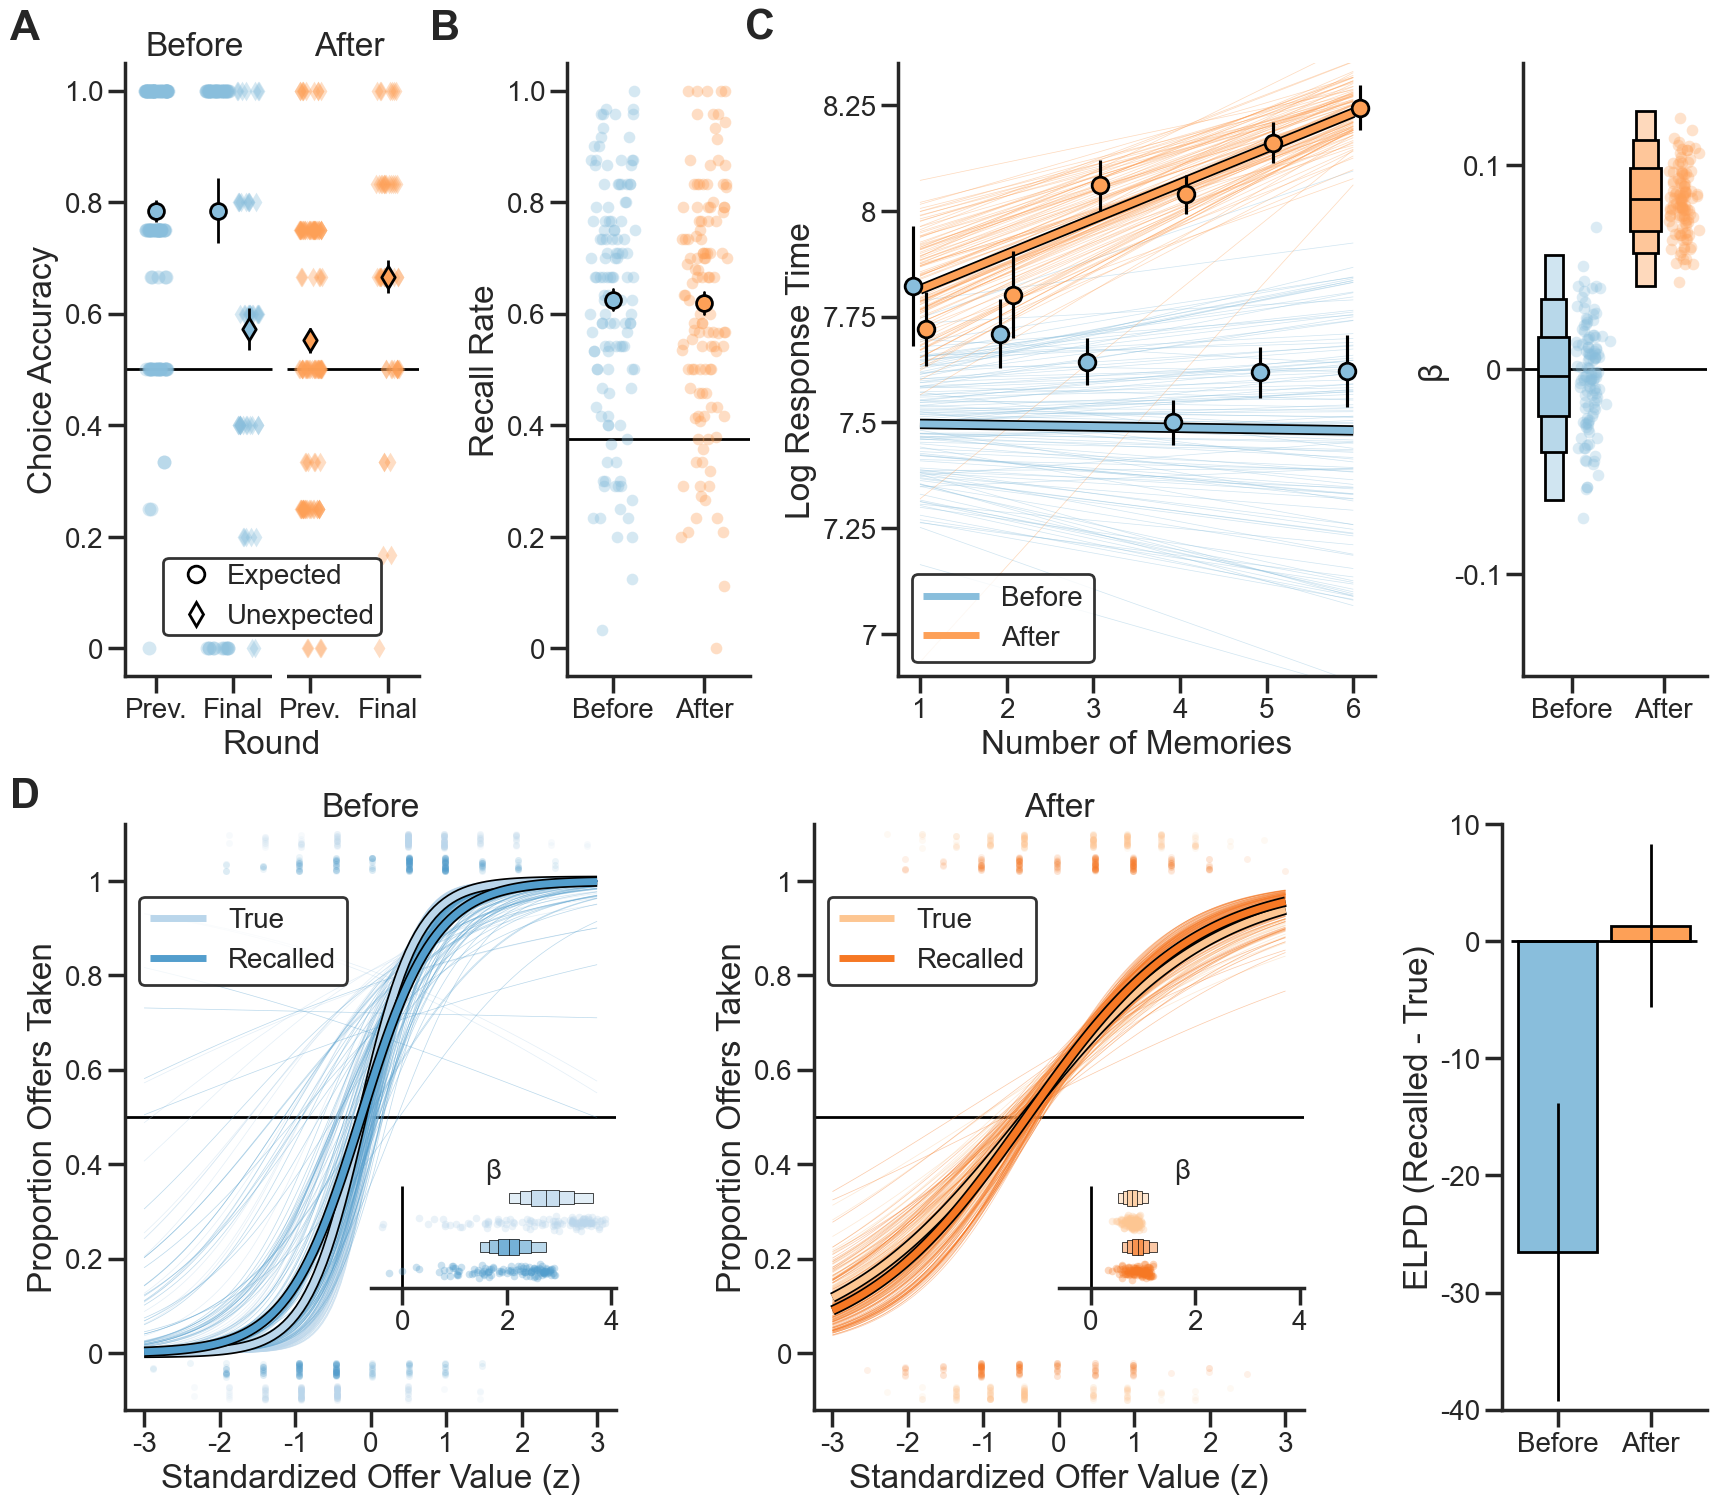

In [183]:
def plot_choice_effects(true_choice_effects, mem_choice_effects, data, exp_num, main_ax, palette):
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes
    """
    Create figure showing logistic regression effects for true and memory value choice effects.
    """
    # Function to compute logistic curve
    def logistic(x, intercept, slope):
        return 1 / (1 + np.exp(-(intercept + slope * x)))

    # Function to get model parameters
    def get_model_params(df, model_name, intercept_param, slope_param):
        intercept = df.loc[df['parameter'] == intercept_param, 'estimate'].values[0]
        slope = df.loc[df['parameter'] == slope_param, 'estimate'].values[0]
        return intercept, slope

    # Plot individual subject lines for both conditions
    def plot_individual_lines(df, model_name, base_intercept, base_slope, color,
                            intercept_pattern, slope_pattern):
        individual_params = df[df['parameter'].str.startswith('r_wid')]
        slopes = []
        for _, row in individual_params.iterrows():
            if intercept_pattern in row['parameter']:
                subj_id = row['parameter'].split('[')[1].split(',')[0]
                subj_intercept = row['estimate'] + base_intercept
                subj_slope_row = individual_params[
                    individual_params['parameter'].str.contains(f"{subj_id},{slope_pattern}")
                ]
                if not subj_slope_row.empty:
                    subj_slope = subj_slope_row['estimate'].values[0] + base_slope
                    main_ax.plot(x, logistic(x, subj_intercept, subj_slope),
                            color=color, alpha=0.4, linewidth=0.5) #0.3, 0.2
                    slopes.append(subj_slope)
        return slopes

    # Plot uncertainty bands and main lines for both conditions
    def plot_condition(df, model_name, intercept_param, slope_param, color, label):
        # Plot main line
        intercept = df.loc[df['parameter'] == intercept_param, 'estimate'].values[0]
        slope = df.loc[df['parameter'] == slope_param, 'estimate'].values[0]
        main_ax.plot(x, logistic(x, intercept, slope),
                color='k', linewidth=7.5, label='_nolegend_')
        main_ax.plot(x, logistic(x, intercept, slope),
                 color=color, linewidth=5, label=label)
        return slope

    # Function to plot model effects with CIs
    def plot_forest_effect(y_pos, slope, df, param_name, color):
        # Convert hex to RGB
        rgb = int(color[1:], 16)
        base_rgb = ((rgb >> 16) & 255, (rgb >> 8) & 255, rgb & 255)
        base_rgb = tuple(x/255 for x in base_rgb)

        # Function to blend color with white based on alpha
        def blend_with_white(rgb, alpha):
            return tuple(c * alpha + (1 - alpha) for c in rgb)

        # Plot random effects
        if param_name == 'b_value_z':
            slopes = true_indiv_slopes
        else:
            slopes = mem_indiv_slopes
        jitter = np.random.normal(0, 0.1, len(slopes))
        forest_ax.scatter([s for s in slopes], [y_pos + j for j in jitter],
                         color=color, alpha=0.3, s=30, zorder=1, linewidth=0)

        # Plot CIs with decreasing thickness and alpha
        y_offset = 0.75
        for ci_level, height, alpha in zip(['95', '80', '50'], [0.3, 0.4, 0.5], [0.4, 0.6, 0.8]):
            ci_lower = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_lower'].values[0]
            ci_upper = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_upper'].values[0]

            # Calculate solid color equivalent to alpha blending with white
            solid_color = blend_with_white(base_rgb, alpha)

            # Add colored CI rectangle
            forest_ax.add_patch(plt.Rectangle((ci_lower, (y_pos+y_offset) - height/2),
                                            ci_upper - ci_lower, height,
                                            facecolor=solid_color, alpha=1.0, #1.0
                                            edgecolor='black', linewidth=0.5,
                                            zorder=3)) #3

        # Plot main effect as vertical black line
        forest_ax.vlines(x=slope, ymin=(y_pos+y_offset)-0.5/2, ymax=(y_pos+y_offset)+0.5/2,
                        color='black', linewidth=0.5, zorder=4)

    # Generate x values for plotting
    x = np.linspace(-3, 3, 100)

    # Define colors for each condition
    true_color = palette[0]
    mem_color = palette[1]

    # Get parameters for both models
    true_intercept, true_slope = get_model_params(
        true_choice_effects, 'true', 'b_Intercept', 'b_value_z'
    )
    mem_intercept, mem_slope = get_model_params(
        mem_choice_effects, 'memory', 'b_Intercept', 'b_recalled_mem_value_z'
    )

    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        # Get individual slopes and plot main logistic regression
        true_indiv_slopes = plot_individual_lines(true_choice_effects, 'true', true_intercept, true_slope,
                             true_color, 'Intercept', 'value_z')
        mem_indiv_slopes = plot_individual_lines(mem_choice_effects, 'memory', mem_intercept, mem_slope,
                             mem_color, 'Intercept', 'recalled_mem_value_z')

        true_slope = plot_condition(true_choice_effects, 'true', 'b_Intercept', 'b_value_z',
                      true_color, 'True')
        mem_slope = plot_condition(mem_choice_effects, 'memory', 'b_Intercept', 'b_recalled_mem_value_z',
                      mem_color, 'Recalled')

    # Customize the main plot
    main_ax.set_xlabel('Standardized Offer Value (z)', size=24)
    main_ax.set_ylabel('Proportion Offers Taken', size=24)
    main_ax.plot((-3.25,3.25),(0.5,0.5),'k',zorder=0,linewidth=2)
    main_ax.set_ylim(-0.12, 1.12)
    main_ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    main_ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1],size=20)
    main_ax.set_xlim(-3.25,3.25)
    main_ax.set_xticks([-3,-2,-1,0,1,2,3])
    main_ax.set_xticklabels([-3,-2,-1,0,1,2,3],size=20)
    main_ax.set_title(exp_num, size=24)
    leg = main_ax.legend(loc='upper left', bbox_to_anchor=(0.0, 0.9), fontsize=20)
    leg.get_frame().set_edgecolor('black')
    sns.despine(ax=main_ax)

    # Add scatter plots for choices
    # For choices = 1 (top of plot)
    choices_1 = data[data['choice'] == 1]
    # Plot recalled values
    main_ax.scatter(choices_1['recalled_mem_value_z'],
                   np.random.uniform(1.02, 1.05, size=len(choices_1)),
                   color=mem_color, alpha=0.1, s=25, linewidth=0)
    # Plot true values
    main_ax.scatter(choices_1['value_z'],
                   np.random.uniform(1.07, 1.1, size=len(choices_1)),
                   color=true_color, alpha=0.1, s=25, linewidth=0)

    # For choices = 0 (bottom of plot)
    choices_0 = data[data['choice'] == 0]
    # Plot recalled values
    main_ax.scatter(choices_0['recalled_mem_value_z'],
                   np.random.uniform(-0.05, -0.02, size=len(choices_0)),
                   color=mem_color, alpha=0.1, s=25, linewidth=0)
    # Plot true values
    main_ax.scatter(choices_0['value_z'],
                   np.random.uniform(-0.1, -0.07, size=len(choices_0)),
                   color=true_color, alpha=0.1, s=25, linewidth=0)

    # Create inset axes for forest plot
    forest_ax = inset_axes(main_ax,
                          width="100%", height="75%",
                          loc='center',
                          bbox_to_anchor=(0.5, 0.18, 0.5, 0.23),
                          bbox_transform=main_ax.transAxes)

    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        # Plot vertical line at 0
        forest_ax.axvline(x=0, color='k', linestyle='-', alpha=1, zorder=0, linewidth=2)

        # Plot effects for both models
        plot_forest_effect(1, mem_slope, mem_choice_effects, 'b_recalled_mem_value_z', mem_color)
        plot_forest_effect(2.5, true_slope, true_choice_effects, 'b_value_z', true_color)

    # Customize forest plot
    forest_ax.set_ylim(0.5, 3.6) #2.5
    forest_ax.set_yticks([])
    forest_ax.set_yticklabels([])
    forest_ax.set_title('β',fontsize=20)

    sns.despine(ax=forest_ax, left=True)

    return forest_ax

def plot_log_rt_effects(rt_effects, data, exp_num, main_ax, color, offset, label):
    """
    Create figure showing RT effects for memory condition in log space.
    """
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # Function to get model parameters
    def get_model_params(df, intercept_param, slope_param):
        intercept = df.loc[df['parameter'] == intercept_param, 'estimate'].values[0]
        slope = df.loc[df['parameter'] == slope_param, 'estimate'].values[0]
        return intercept, slope

    # Plot individual subject lines
    def plot_individual_lines(df, base_intercept, base_slope, color):
        individual_params = df[df['parameter'].str.startswith('r_wid')]
        ndt = df.loc[df['parameter'] == 'ndt', 'estimate'].values[0]
        slopes = []
        for _, row in individual_params.iterrows():
            if 'Intercept' in row['parameter']:
                subj_id = row['parameter'].split('[')[1].split(',')[0]
                subj_intercept = row['estimate'] + base_intercept
                subj_slope_row = individual_params[
                    individual_params['parameter'].str.contains(f"{subj_id},n_total_memories_shown")
                ]
                if not subj_slope_row.empty:
                    subj_slope = subj_slope_row['estimate'].values[0] + base_slope
                    y_vals = subj_intercept + subj_slope * x
                    main_ax.plot(x, y_vals, color=color, alpha=0.4, linewidth=0.5, zorder=0)
                    slopes.append(subj_slope)
        return slopes

    # Plot main line
    def plot_condition(df, intercept_param, slope_param, color, label):
        intercept = df.loc[df['parameter'] == intercept_param, 'estimate'].values[0]
        slope = df.loc[df['parameter'] == slope_param, 'estimate'].values[0]
        y_vals = intercept + slope * x
        # Plot the black edge first (slightly thicker)
        main_ax.plot(x, y_vals, color='black', linewidth=7.5, label='_nolegend_')  
        # Plot the colored line on top (slightly thinner)
        main_ax.plot(x, y_vals, color=color, linewidth=5, label=label)
        return slope

    # Generate x values for plotting
    x = np.linspace(1, 6, 6)  # Adjusted range for number of memories

    # Define color for memory condition
    mem_color = color

    # Get parameters for the model
    mem_intercept, mem_slope = get_model_params(
        rt_effects, 'b_Intercept', 'b_n_total_memories_shown'
    )

    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        # Get individual slopes and plot main regression
        slopes = plot_individual_lines(rt_effects, mem_intercept, mem_slope, mem_color)
        main_slope = plot_condition(rt_effects, 'b_Intercept', 'b_n_total_memories_shown',
                                  mem_color, label)

        # Plot the data
        d = data.dropna()
        # Create bins specifically for values 1-6
        memory_values = np.arange(1, 7)
        bin_means = []
        bin_stds = []

        # Calculate mean and std for each discrete value
        for val in memory_values:
            val_data = np.log(d[d['n_total_memories'] == val]['rt'])
            val_data = val_data[~np.isinf(val_data)]
            if len(val_data) > 0:  # Check if we have data for this value
                bin_means.append(np.mean(val_data))
                bin_stds.append(stats.sem(val_data))
            else:
                bin_means.append(np.nan)
                bin_stds.append(np.nan)

        bin_means = np.array(bin_means)
        bin_stds = np.array(bin_stds)

        # Get lower and upper error bar edges
        bin_lower = bin_means - bin_stds
        bin_upper = bin_means + bin_stds

        # Apply offset to x-values
        bin_centers = memory_values + offset

        # Adding error bars with matplotlib
        main_ax.errorbar(bin_centers, bin_means,
                        yerr=[bin_means - bin_lower, bin_upper - bin_means],
                        fmt='o', mec='black', mew=2,
                        color=mem_color, ecolor='black', elinewidth=2.25,
                        capsize=0, zorder=200)

    # Customize the main plot
    main_ax.set_xlabel('Number of Memories', size=24)
    main_ax.set_ylabel('Log Response Time', size=24)
    # main_ax.set_title(f"Experiment {exp_num}", size=24)
    main_ax.set_xlim(0.75, 6.25)
    main_ax.set_xticks([1,2,3,4,5,6])
    main_ax.set_xticklabels([1,2,3,4,5,6], size=20)
    main_ax.set_ylim(6.9, 8.35)  # Adjusted for log scale
    main_ax.set_yticks([7, 7.25, 7.5, 7.75, 8, 8.25])
    main_ax.set_yticklabels([7, 7.25, 7.5, 7.75, 8, 8.25], size=20)
    leg = main_ax.legend(loc='lower left', fontsize=20)
    leg.get_frame().set_edgecolor('black')
    
    sns.despine(ax=main_ax)

def plot_forest_effect(y_pos, slope, df, param_name, color, ax):
    rgb = int(color[1:], 16)
    base_rgb = ((rgb >> 16) & 255, (rgb >> 8) & 255, rgb & 255)
    base_rgb = tuple(x/255 for x in base_rgb)

    def blend_with_white(rgb, alpha):
        return tuple(c * alpha + (1 - alpha) for c in rgb)

    # Get individual slopes
    individual_params = df[df['parameter'].str.startswith('r_wid')]
    slopes = []
    for _, row in individual_params.iterrows():
        if 'Intercept' in row['parameter']:
            subj_id = row['parameter'].split('[')[1].split(',')[0]
            slope_row = individual_params[
                individual_params['parameter'].str.contains(f"{subj_id},n_total_memories_shown")
            ]
            if not slope_row.empty:
                slopes.append(slope_row['estimate'].values[0] + slope)

    x_offset = 0.4
    point_pos = y_pos + x_offset + 0.2  # Store point position
    jitter = np.random.normal(0, 0.1, len(slopes))
    ax.scatter([point_pos + j for j in jitter], [s for s in slopes],
               color=color, alpha=0.3, s=70, zorder=1, linewidth=0)  # Increased s from 30 to 50

    # Plot CIs with decreasing thickness and alpha
    for ci_level, width, alpha in zip(['95', '80', '50'], [0.3, 0.4, 0.5], [0.4, 0.6, 0.8]):
        ci_lower = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_lower'].values[0]
        ci_upper = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_upper'].values[0]

        solid_color = blend_with_white(base_rgb, alpha)

        ax.add_patch(plt.Rectangle((y_pos - width/2, ci_lower),
                                 width, ci_upper - ci_lower,
                                 facecolor=solid_color, alpha=1.0,
                                 edgecolor='black', linewidth=2,
                                 zorder=3))

    # Plot main effect line
    ax.hlines(y=slope, xmin=y_pos-0.5/2, xmax=y_pos+0.5/2,
             color='black', linewidth=2, zorder=4)

    return (y_pos + point_pos) / 2  # Return position for xtick

# Create the overall figure
fig = plt.figure(figsize=(17.5, 14.5))

gs1 = plt.GridSpec(2, 4, height_ratios=[1, 1], width_ratios=[4, 2.5, 6.5, 2.5])


gs2 = plt.GridSpec(2, 3, height_ratios=[1, 1], width_ratios=[6, 6, 2.5], wspace=0.5,
                   hspace=0.3) # Bottom Row, 0.6

# Then create your subplots
# Top row
ax6 = fig.add_subplot(gs1[0,0])  # Combined plot
ax8 = fig.add_subplot(gs1[0,1])
ax4 = fig.add_subplot(gs1[0,2])
ax5 = fig.add_subplot(gs1[0,3])

# Bottom row
ax1 = fig.add_subplot(gs2[1,0])
ax2 = fig.add_subplot(gs2[1,1])
ax3 = fig.add_subplot(gs2[1,2])

# Create figure
# Colors
before_color = sns.color_palette("Blues").as_hex()[2]
after_color = sns.color_palette("Oranges").as_hex()[2]

with plt.rc_context({'lines.solid_capstyle': 'butt'}):
    # Add jitter to x positions
    after_jitter = 0.15
    before_jitter = 0.15
    dodge_amount = 0.2

    x_offset_before = 0
    x_offset_after = 2

    # Before condition - Full
    x_jitter = np.random.uniform(-before_jitter, before_jitter, size=len(full_before)) + x_offset_before
    ax6.scatter(x_jitter, full_before['correct'],
            alpha=0.35, s=100, linewidth=0, color=before_color, marker='o')

    # Before last data - Expected
    x_jitter = np.random.uniform(-before_jitter, before_jitter, size=len(last_before_exp)) + (1 - dodge_amount)
    ax6.scatter(x_jitter, last_before_exp['correct'],
            alpha=0.35, s=100, linewidth=0, color=before_color, marker='o')

    # Before last data - Unexpected
    x_jitter = np.random.uniform(-before_jitter, before_jitter, size=len(last_before_unexp)) + (1 + dodge_amount)
    ax6.scatter(x_jitter, last_before_unexp['correct'],
            alpha=0.35, s=100, linewidth=0, color=before_color, marker='d')

    # After condition - Full
    x_jitter = np.random.uniform(-after_jitter, after_jitter, size=len(full_after)) + x_offset_after
    ax6.scatter(x_jitter, full_after['correct'],
            alpha=0.35, s=100, linewidth=0, color=after_color, marker='d')

    # After condition - Last
    x_jitter = np.random.uniform(-after_jitter, after_jitter, size=len(last_after)) + (1 + x_offset_after)
    ax6.scatter(x_jitter, last_after['correct'],
            alpha=0.35, s=100, linewidth=0, color=after_color, marker='d')

    # Error bars and means
    # Before condition - Full
    mean = full_before['correct'].mean()
    sem = full_before['correct'].std() / np.sqrt(len(full_before))
    ax6.plot([x_offset_before, x_offset_before], [mean-sem, mean+sem], color='k', linewidth=2, zorder=3)
    ax6.scatter([x_offset_before], [mean], s=130, color=before_color, edgecolor='k', linewidth=2, zorder=4, marker='o')

    # Last round - Expected (Before)
    mean = last_before_exp['correct'].mean()
    sem = last_before_exp['correct'].std() / np.sqrt(len(last_before_exp))
    ax6.plot([1-dodge_amount, 1-dodge_amount], [mean-sem, mean+sem], color='k', linewidth=2, zorder=3)
    ax6.scatter([1-dodge_amount], [mean], s=130, color=before_color, edgecolor='k', linewidth=2, zorder=4, marker='o')

    # Last round - Unexpected (Before)
    mean = last_before_unexp['correct'].mean()
    sem = last_before_unexp['correct'].std() / np.sqrt(len(last_before_unexp))
    ax6.plot([1+dodge_amount, 1+dodge_amount], [mean-sem, mean+sem], color='k', linewidth=2, zorder=3)
    ax6.scatter([1+dodge_amount], [mean], s=130, color=before_color, edgecolor='k', linewidth=2, zorder=4, marker='d')

    # After condition
    # Full
    mean = full_after['correct'].mean()
    sem = full_after['correct'].std() / np.sqrt(len(full_after))
    ax6.plot([x_offset_after, x_offset_after], [mean-sem, mean+sem], color='k', linewidth=2, zorder=3)
    ax6.scatter([x_offset_after], [mean], s=130, color=after_color, edgecolor='k', linewidth=2, zorder=4, marker='d')
    
    # Last
    mean = last_after['correct'].mean()
    sem = last_after['correct'].std() / np.sqrt(len(last_after))
    x_pos = 1 + x_offset_after
    ax6.plot([x_pos, x_pos], [mean-sem, mean+sem], color='k', linewidth=2, zorder=3)
    ax6.scatter([x_pos], [mean], s=130, color=after_color, edgecolor='k', linewidth=2, zorder=4, marker='d')

    # Plot customization
    ax6.set_ylim(-0.05, 1.05)
    ax6.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax6.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], size=20)
    ax6.set_ylabel('Choice Accuracy', size=24)

    ax6.set_xticks([x_offset_before, 1, x_offset_after, x_offset_after + 1])
    ax6.set_xticklabels(['Prev.', 'Final', 'Prev.', 'Final'], size=20)
    ax6.set_xlim(-0.4, 3.4)

    ax6.text(0.5, 1.05, 'Before', ha='center', va='bottom', size=24)
    ax6.text(2.5, 1.05, 'After', ha='center', va='bottom', size=24)

    ax6.plot((-0.5, 1.5), (0.5, 0.5), 'k', linewidth=2, zorder=0)
    ax6.plot((1.7, 3.5), (0.5, 0.5), 'k', linewidth=2, zorder=0)

    ax6.set_xlabel('Round', size=24)

    ax6.add_patch(plt.Rectangle((1.5, -0.085), 0.2, 0.1,
                          facecolor='white', edgecolor='none',
                          clip_on=False,
                          zorder=100))

sns.despine(ax=ax6)

# Add legend with custom elements
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='w', markeredgewidth=2,
           markeredgecolor='k', markersize=12, linewidth=0, label='Expected'),
    Line2D([0], [0], marker='d', color='w', markerfacecolor='w', markeredgewidth=2,
           markeredgecolor='k', markersize=12, linewidth=0, label='Unexpected')]
ax6.legend(handles=legend_elements, fontsize=20, handletextpad=0.1, borderpad=0.2,
          bbox_to_anchor=(0.5, 0.13), loc='center',ncol=1, edgecolor='black');

# Plot the recall result
recall_4["Experiment"] = "4"
# Calculate means and SEMs for second plot
means2 = recall_4.groupby(['Experiment', 'multi_time'])['recall_rate'].mean()
sems2 = recall_4.groupby(['Experiment', 'multi_time'])['recall_rate'].sem()

ax = ax8

# Chance line first (lowest zorder)
ax.plot((-0.5, 0.5), (6/16, 6/16), 'k', linewidth=2, zorder=0)

# Manual error bars and points with dodge
dodge_amount = 0.2
for time_idx, (time, color) in enumerate([('Before', before_color), ('After', after_color)]):
    mean = means2['4'][time]
    sem = sems2['4'][time]
    x_pos = time_idx * 2 * dodge_amount - dodge_amount
    
    # Plot individual points first
    data_points = recall_4[recall_4['multi_time'] == time]
    x_jitter = np.random.uniform(-0.1, 0.1, size=len(data_points))
    ax.scatter(x_pos + x_jitter, data_points['recall_rate'],
              color=color, alpha=0.35, s=70, linewidth=0, zorder=1)

    # Error bars
    ax.plot([x_pos, x_pos], [mean-sem, mean+sem],
             color='k', linewidth=2, zorder=2)
    # Point with black edge, colored fill
    ax.scatter([x_pos], [mean], s=130, color=color,
               edgecolor='k', linewidth=2, zorder=3)

# Customize both plots
ax.set_ylabel('Recall Rate', size=24)
ax.set_ylim(-0.05, 1.05)
ax.set_xlim(-0.4, 0.4)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0], size=20)
ax.set_xticks([-dodge_amount, dodge_amount])
ax.set_xticklabels(['Before', 'After'], size=20)
#ax.legend_.remove()
sns.despine(ax=ax)


# Create the plots
before_palette = [sns.color_palette("Blues").as_hex()[1],sns.color_palette("Blues").as_hex()[3]]
after_palette = [sns.color_palette("Oranges").as_hex()[1],sns.color_palette("Oranges").as_hex()[3]]
forest_ax1 = plot_choice_effects(before_true_choice_effects_4, before_mem_choice_effects_4, before_4, "Before", ax1, before_palette)
forest_ax2 = plot_choice_effects(after_true_choice_effects_4, after_mem_choice_effects_4, after_4, "After", ax2, after_palette)
# Get the global min/max for x-axis limits across all forest plots
x_min = min(forest_ax1.get_xlim()[0], forest_ax2.get_xlim()[0])
x_max = max(forest_ax1.get_xlim()[1],forest_ax2.get_xlim()[1])
for ax in [forest_ax1, forest_ax2]:
    # Make x-axes consistent for all forest plots
    ax.set_xlim(x_min, x_max)
    ax.locator_params(axis='x', nbins=3)
    ax.tick_params(axis='x', labelsize=20)

elpd_diffs = [[elpd_4[elpd_4.timepoint == "Before"],elpd_4[elpd_4.timepoint == "After"]]]
colors = [sns.color_palette("Blues").as_hex()[2],sns.color_palette("Oranges").as_hex()[2]]
axes = [ax3]
with plt.rc_context({'lines.solid_capstyle': 'butt'}):
    for i, samp in enumerate(["4"]):
        ax = axes[i]
        for j in range(2):
            edf = elpd_diffs[i][j]
            ax.bar(j, edf.elpd_diff, color=colors[j], linewidth=2, edgecolor="0", width=0.85)
            ax.plot((j,j), (edf.elpd_diff+edf.se_diff, edf.elpd_diff-edf.se_diff),linewidth=2, color='k')
        ax.set_ylim(-40,10)
        ax.set_yticks([-40,-30,-20,-10,0,10])
        ax.set_yticklabels([-40,-30,-20,-10,0,10], fontsize=20)
        ax.set_xticks([0,1])
        ax.set_xticklabels(["Before","After"], fontsize=20)
        #ax.set_xlabel("Condition", fontsize=24)
        ax.set_ylabel("ELPD (Recalled - True)", fontsize=24)
        ax.plot((-0.5,1.5), (0,0), 'k', linewidth=2)
        sns.despine(ax=ax)

# Move on to RT effects now
plot_log_rt_effects(rt_effects_4[rt_effects_4.model == "before_memory"], before_4_full, "4", ax4, 
                    sns.color_palette("Blues").as_hex()[2], offset=-0.075, label="Before")
plot_log_rt_effects(rt_effects_4[rt_effects_4.model == "after_memory"], after_4_full, "4", ax4, 
                    sns.color_palette("Oranges").as_hex()[2], offset=0.075, label="After")

axes = [ax5]
rt_effects_dsets = [rt_effects_4]
for i, ax in enumerate(axes):
    rt_effect_dset = rt_effects_dsets[i]
    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        # Plot horizontal line at 0
        ax.axhline(y=0, color='k', linestyle='-', alpha=1, zorder=0, linewidth=2)

        mem_color = '#A9A9A9'
        xtick_positions = []

        # Dataset 3A BEFORE
        before_rt_effects = rt_effect_dset[rt_effect_dset.model == "before_memory"]
        before_main_slope = before_rt_effects.loc[before_rt_effects['parameter'] == "b_n_total_memories_shown", 'estimate'].values[0]
        xtick_positions.append(plot_forest_effect(0.5, before_main_slope, before_rt_effects, 'b_n_total_memories_shown',
                                                  sns.color_palette("Blues").as_hex()[2], ax))

        # Dataset 3A AFTER
        after_rt_effects = rt_effect_dset[rt_effect_dset.model == "after_memory"]
        after_main_slope = after_rt_effects.loc[after_rt_effects['parameter'] == "b_n_total_memories_shown", 'estimate'].values[0]
        xtick_positions.append(plot_forest_effect(2, after_main_slope, after_rt_effects, 'b_n_total_memories_shown',
                                                  sns.color_palette("Oranges").as_hex()[2], ax))

        # Set x-axis ticks and labels at the middle positions
        ax.set_xticks(xtick_positions)
        ax.set_xticklabels(['Before', 'After'], fontsize=20)
        ax.set_xlim(0, 3)
        ax.set_ylabel('β', fontsize=24)
        ax.set_ylim(-0.15, 0.15)
        ax.set_yticks([-0.1, 0, 0.1])
        ax.set_yticklabels([-0.1, 0, 0.1], fontsize=20)

        sns.despine(ax=ax)

fig.text(0.01, 0.97, 'A', fontsize=30, fontweight='bold')
fig.text(0.25, 0.97, 'B', fontsize=30, fontweight='bold')
fig.text(0.43, 0.97, 'C', fontsize=30, fontweight='bold')
fig.text(0.01, 0.44, 'D', fontsize=30, fontweight='bold');

plt.tight_layout();
plt.savefig("figures/Figure4.pdf", bbox_inches='tight')


# Print performance summary stats

In [ ]:
# Function to calculate and print stats
def print_recall_stats(df, exp_name):
    mean = df['recall_rate'].mean()
    sem = df['recall_rate'].sem()
    print(f"Experiment {exp_name}: {mean:.3f} ± {sem:.3f}")

print("Recall rates:")
# Calculate stats for each experiment
print_recall_stats(recall_1a, "1A")
print_recall_stats(recall_1b, "1B")
print_recall_stats(recall_2, "2")
print_recall_stats(before_recall_3a, "Before 3A")
print_recall_stats(after_recall_3a, "After 3A")
print_recall_stats(before_recall_3b, "Before 3B")
print_recall_stats(after_recall_3b, "After 3B")
print_recall_stats(before_recall_4, "Before 4")
print_recall_stats(after_recall_4, "After 4")

print("Choice accuracy:")

overall_perf_1a = data_1a_full.dropna().groupby(["wid"]).correct.agg(['mean', 'std']).reset_index()
print(f"Exp 1A: Overall performance:")
print(f"Mean: {overall_perf_1a['mean'].mean()*100:.1f}% ± {overall_perf_1a['mean'].std()/np.sqrt(len(overall_perf_1a))*100:.1f}%")

overall_perf_1b = data_1b_full.dropna().groupby(["wid"]).correct.agg(['mean', 'std']).reset_index()
print(f"Exp 1B: Overall performance:")
print(f"Mean: {overall_perf_1b['mean'].mean()*100:.1f}% ± {overall_perf_1b['mean'].std()/np.sqrt(len(overall_perf_1b))*100:.1f}%")

overall_perf_2 = data_2_full.dropna().groupby(["wid"]).correct.agg(['mean', 'std']).reset_index()
print(f"Exp 2: Overall performance:")
print(f"Mean: {overall_perf_2['mean'].mean()*100:.1f}% ± {overall_perf_2['mean'].std()/np.sqrt(len(overall_perf_2))*100:.1f}%")

overall_perf_before_3a = before_3a_full.dropna().groupby(["wid"]).correct.agg(['mean', 'std']).reset_index()
print(f"Exp 3A Before: Overall performance:")
print(f"Mean: {overall_perf_before_3a['mean'].mean()*100:.1f}% ± {overall_perf_before_3a['mean'].std()/np.sqrt(len(overall_perf_before_3a))*100:.1f}%")
overall_perf_after_3a = after_3a_full.dropna().groupby(["wid"]).correct.agg(['mean', 'std']).reset_index()
print(f"Exp 3A After: Overall performance:")
print(f"Mean: {overall_perf_after_3a['mean'].mean()*100:.1f}% ± {overall_perf_after_3a['mean'].std()/np.sqrt(len(overall_perf_after_3a))*100:.1f}%")
overall_perf_before_3b = before_3b_full.dropna().groupby(["wid"]).correct.agg(['mean', 'std']).reset_index()
print(f"Exp 3B Before: Overall performance:")
print(f"Mean: {overall_perf_before_3b['mean'].mean()*100:.1f}% ± {overall_perf_before_3b['mean'].std()/np.sqrt(len(overall_perf_before_3b))*100:.1f}%")

print(f"Exp 4 Before: Overall performance:")
print(f"Mean: {full_before['correct'].mean()*100:.1f}% ± {full_before['correct'].std()/np.sqrt(len(full_before))*100:.1f}%")
print(f"Exp 4: Last round Expected, Before:")
print(f"Mean: {last_before_exp['correct'].mean()*100:.1f}% ± {last_before_exp['correct'].std()/np.sqrt(len(last_before_exp))*100:.1f}%")
print(f"Exp 4: Last round Unexpected, Before:")
print(f"Mean: {last_before_unexp['correct'].mean()*100:.1f}% ± {last_before_unexp['correct'].std()/np.sqrt(len(last_before_unexp))*100:.1f}%")
print(f"Exp 4: After: Overall performance:")
print(f"Mean: {full_after['correct'].mean()*100:.1f}% ± {full_after['correct'].std()/np.sqrt(len(full_after))*100:.1f}%")
print(f"Exp 4: Last round, After:")
print(f"Mean: {last_after['correct'].mean()*100:.1f}% ± {last_after['correct'].std()/np.sqrt(len(last_after))*100:.1f}%")


Recall rates:
Experiment 1A: 0.630 ± 0.025
Experiment 1B: 0.647 ± 0.028
Experiment 2: 0.606 ± 0.024
Experiment Before 3A: 0.518 ± 0.032
Experiment After 3A: 0.511 ± 0.029
Experiment Before 3B: 0.618 ± 0.022
Experiment After 3B: 0.612 ± 0.023
Experiment Before 4: 0.625 ± 0.019
Experiment After 4: 0.619 ± 0.019
Choice accuracy:
Exp 1A: Overall performance:
Mean: 63.6% ± 1.5%
Exp 1B: Overall performance:
Mean: 60.8% ± 2.3%
Exp 2: Overall performance:
Mean: 62.4% ± 1.3%
Exp 3A Before: Overall performance:
Mean: 68.5% ± 2.9%
Exp 3A After: Overall performance:
Mean: 59.7% ± 2.9%
Exp 3B Before: Overall performance:
Mean: 71.7% ± 1.9%
Exp 4: Before:
Mean: 78.4% ± 2.0%
Exp 4: Last round Expected, Before:
Mean: 78.4% ± 5.8%
Exp 4: Last round Unexpected, Before:
Mean: 57.3% ± 3.7%
Exp 4: After:
Mean: 55.2% ± 2.2%
Exp 4: Last round, After:
Mean: 66.7% ± 3.0%


In [186]:
def calculate_elpd(exp_id, multi_time=None):
    """
    Print ELPD values for a given experiment and condition.
    """
    # Construct file path based on experiment and condition
    file_path = curr_wd + "/output/choice_elpd_diff_raw"
    if multi_time:
        file_path += f"_{multi_time.lower()}"
    file_path += f"_{exp_id}.csv"
    
    # Load raw ELPD data
    elpd_raw = pd.read_csv(file_path)
    
    # Calculate memory model ELPD
    elpd_mem = np.sum(elpd_raw["elpd_mem"])
    elpd_mem_se = np.sqrt(len(elpd_raw["elpd_mem"])) * np.std(elpd_raw["elpd_mem"])
    
    # Calculate true model ELPD  
    elpd_true = np.sum(elpd_raw["elpd_true"])
    elpd_true_se = np.sqrt(len(elpd_raw["elpd_true"])) * np.std(elpd_raw["elpd_true"])
    
    # Print results
    if multi_time:
        print(f"Exp {exp_id} - {multi_time}")
    else:
        print(f"Exp {exp_id}")
    print(f"Memory ELPD: {elpd_mem:.3f} ± {elpd_mem_se:.3f}")
    print(f"True ELPD: {elpd_true:.3f} ± {elpd_true_se:.3f}")
    print()
    
    return elpd_mem, elpd_mem_se, elpd_true, elpd_true_se

# Calculate ELPD for experiments 1A, 1B, 2
for exp in ['1A', '1B', '2']:
    calculate_elpd(exp)

# Calculate ELPD for experiments 3A, 3B, 4 with before/after conditions
for exp in ['3A', '3B', '4']:
    for time in ['Before', 'After']:
        calculate_elpd(exp, time)

Exp 1A
Memory ELPD: -856.367 ± 14.031
True ELPD: -877.368 ± 13.318

Exp 1B
Memory ELPD: -342.208 ± 8.538
True ELPD: -355.789 ± 8.352

Exp 2
Memory ELPD: -1040.770 ± 14.370
True ELPD: -1062.249 ± 13.270

Exp 3A - Before
Memory ELPD: -245.557 ± 8.900
True ELPD: -240.816 ± 9.323

Exp 3A - After
Memory ELPD: -243.083 ± 7.552
True ELPD: -256.405 ± 6.679

Exp 3B - Before
Memory ELPD: -434.470 ± 13.308
True ELPD: -446.728 ± 13.332

Exp 3B - After
Memory ELPD: -441.225 ± 13.005
True ELPD: -485.723 ± 10.548

Exp 4 - Before
Memory ELPD: -208.662 ± 11.287
True ELPD: -182.118 ± 13.119

Exp 4 - After
Memory ELPD: -220.334 ± 7.490
True ELPD: -221.666 ± 6.703



# Supplemental Figures

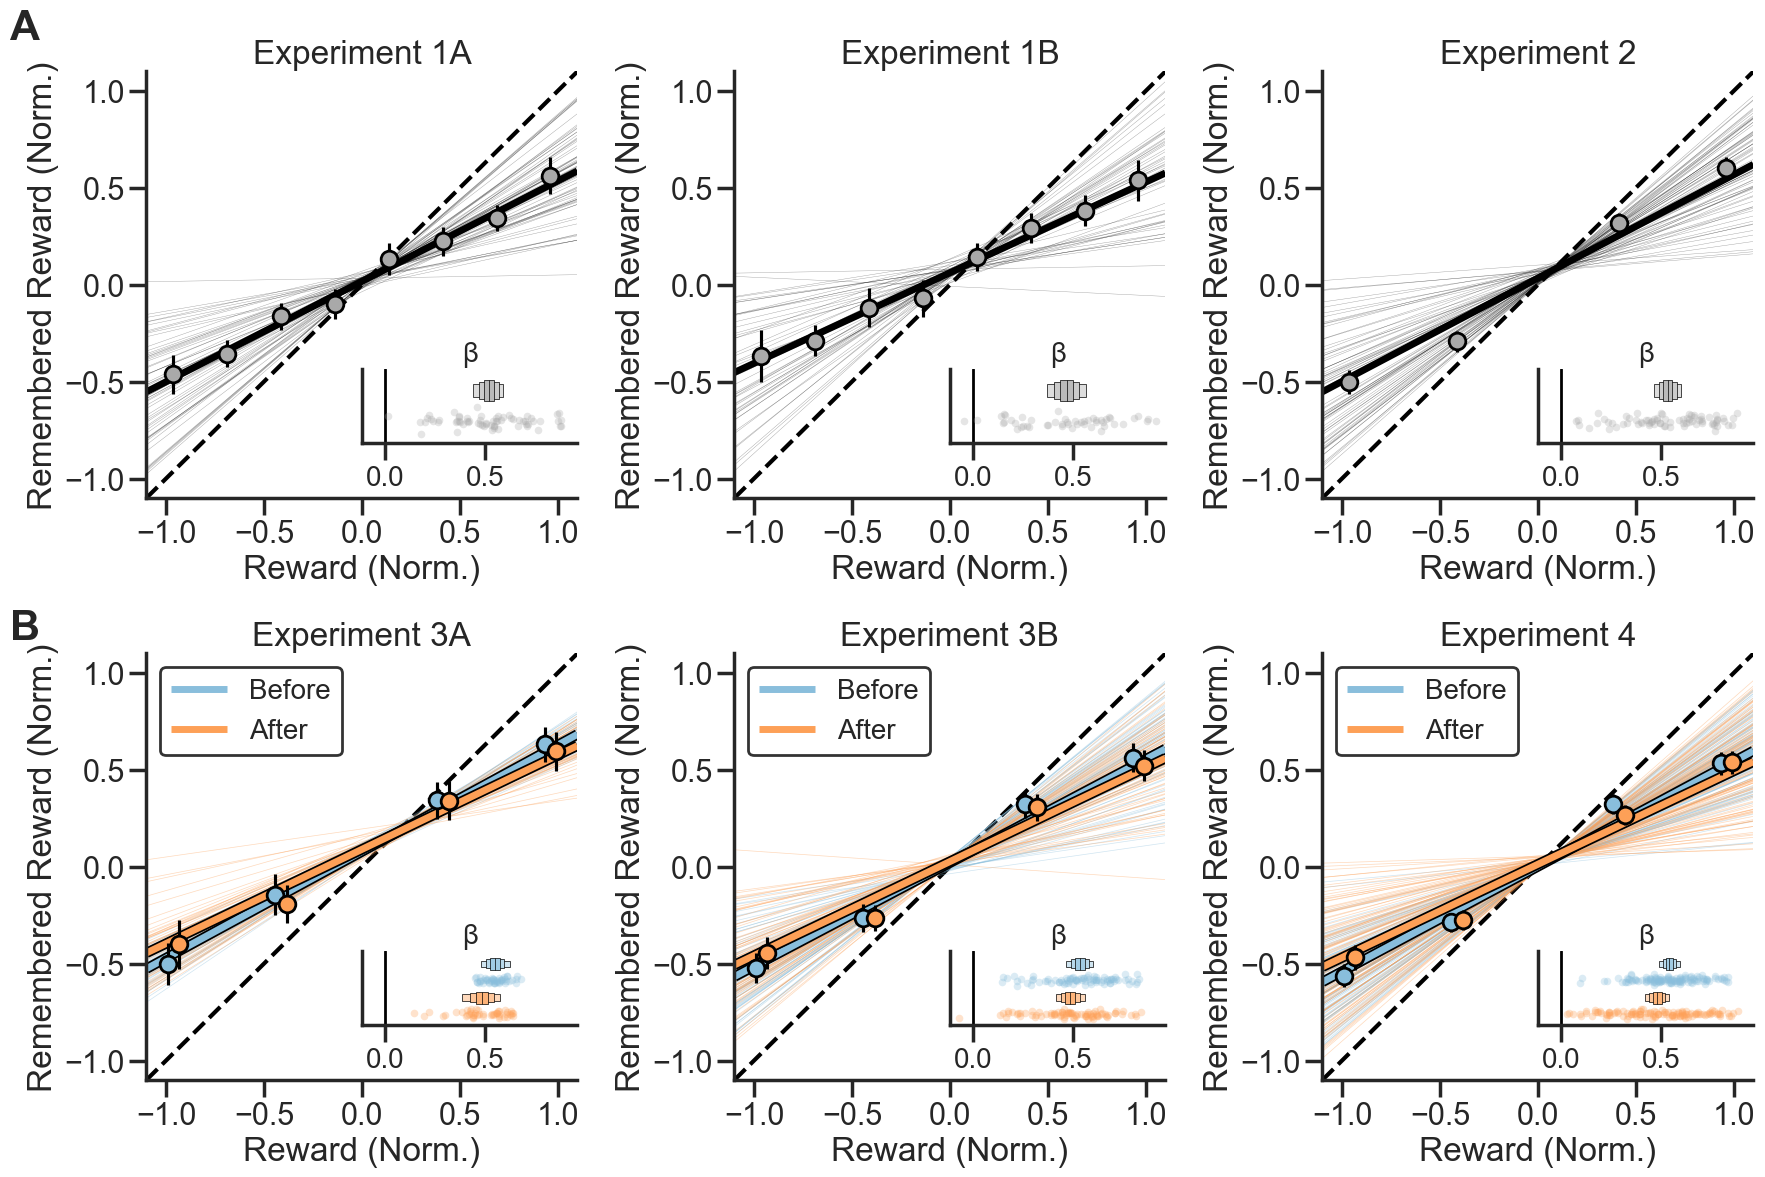

In [121]:
# Supplemental Figure 1: Value Memory

def plot_value_recall_effects(value_effects, data, exp_num, main_ax):
    """
    Create figure showing value recall effects with forest plot inset.
    """
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # Function to get model parameters
    def get_model_params(df):
        intercept = df.loc[df['parameter'] == 'b_Intercept', 'estimate'].values[0]
        slope = df.loc[df['parameter'] == 'b_outcome', 'estimate'].values[0]
        return intercept, slope

    def plot_forest_effect(y_pos, slope, df, param_name, color, ax):
        rgb = int(color[1:], 16)
        base_rgb = ((rgb >> 16) & 255, (rgb >> 8) & 255, rgb & 255)
        base_rgb = tuple(x/255 for x in base_rgb)

        def blend_with_white(rgb, alpha):
            return tuple(c * alpha + (1 - alpha) for c in rgb)

        # Get individual slopes
        individual_params = df[df['parameter'].str.startswith('r_wid')]
        slopes = []
        for _, row in individual_params.iterrows():
            if 'outcome' in row['parameter']:
                slopes.append(row['estimate'] + slope)

        # Plot individual points with jitter at base position
        jitter = np.random.normal(0, 0.1, len(slopes))
        ax.scatter([s for s in slopes], [y_pos + j for j in jitter],
                color=color, alpha=0.3, s=30, zorder=1, linewidth=0)

        # Plot CIs with decreasing thickness and alpha at offset position
        y_offset = 0.75  # Vertical offset for boxes
        for ci_level, height, alpha in zip(['95', '80', '50'], [0.3, 0.4, 0.5], [0.4, 0.6, 0.8]):
            ci_lower = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_lower'].values[0]
            ci_upper = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_upper'].values[0]

            solid_color = blend_with_white(base_rgb, alpha)

            ax.add_patch(plt.Rectangle((ci_lower, (y_pos+y_offset) - height/2),
                                    ci_upper - ci_lower, height,
                                    facecolor=solid_color, alpha=1.0,
                                    edgecolor='black', linewidth=0.5,
                                    zorder=3))

        # Plot main effect as vertical black line at offset position
        ax.vlines(x=slope, ymin=(y_pos+y_offset)-0.5/2, ymax=(y_pos+y_offset)+0.5/2,
                color='black', linewidth=0.5, zorder=4)

        return y_pos
    # Plot individual subject lines
    def plot_individual_lines(df, base_intercept, base_slope, color):
        individual_params = df[df['parameter'].str.startswith('r_wid')]
        slopes = []
        for _, row in individual_params.iterrows():
            if 'Intercept' in row['parameter']:
                subj_id = row['parameter'].split('[')[1].split(',')[0]
                subj_intercept = row['estimate'] + base_intercept
                subj_slope_row = individual_params[
                    individual_params['parameter'].str.contains(f"{subj_id},outcome")
                ]
                if not subj_slope_row.empty:
                    subj_slope = subj_slope_row['estimate'].values[0] + base_slope
                    y_vals = subj_intercept + subj_slope * x
                    main_ax.plot(x, y_vals, color='k', alpha=0.375, linewidth=0.3)
                    slopes.append(subj_slope)
        return slopes

    # Generate x values for plotting
    x = np.linspace(-1.1, 1.1, 100)

    # Get model parameters
    intercept, slope = get_model_params(value_effects)

    # Plot individual and main lines
    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        slopes = plot_individual_lines(value_effects, intercept, slope, '#A9A9A9')
        y_vals = intercept + slope * x
        main_ax.plot(x, y_vals, color='black', linewidth=5)

    # Add diagonal line for perfect memory
    main_ax.plot((-1.1, 1.1), (-1.1, 1.1), 'k--', zorder=0)

    # Plot the data
    d = data.dropna()
    # Create bins
    bins = np.linspace(-1.1, 1.1, 9)  # 8 bins like in the original regplot
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    bin_means = []
    bin_stds = []
    
    # Calculate mean and SEM for each bin
    for i in range(len(bins)-1):
        mask = (d['outcome'] >= bins[i]) & (d['outcome'] < bins[i+1])
        bin_data = d[mask]['remembered_outcome']
        if len(bin_data) > 0:
            bin_means.append(np.mean(bin_data))
            bin_stds.append(stats.sem(bin_data))
        else:
            bin_means.append(np.nan)
            bin_stds.append(np.nan)
    
    bin_means = np.array(bin_means)
    bin_stds = np.array(bin_stds)
    
    # Get lower and upper error bar edges
    bin_lower = bin_means - (1.96 * bin_stds) #bin_stds
    bin_upper = bin_means + (1.96 * bin_stds)
    
    # Adding error bars with matplotlib
    main_ax.errorbar(bin_centers, bin_means,
                    yerr=[bin_means - bin_lower, bin_upper - bin_means],
                    fmt='o', mec='black', mew=2,
                    color='#A9A9A9', ecolor='black', elinewidth=2.25,
                    capsize=0, zorder=200)

    # Plot the data points
    # main_ax.scatter(data['outcome'], data['remembered_outcome'], 
    #                color='gray', alpha=0.1, s=25)

    # Customize the main plot
    main_ax.set_xlabel('Reward (Norm.)', size=24)
    main_ax.set_ylabel('Remembered Reward (Norm.)', size=24)
    main_ax.set_title(f"Experiment {exp_num}", size=24)
    main_ax.set_ylim(-1.1, 1.1)
    main_ax.set_xlim(-1.1, 1.1)
    main_ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    main_ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    sns.despine(ax=main_ax)

    # Create inset axes for forest plot
    forest_ax = inset_axes(main_ax,
                          width="100%", height="75%",
                          loc='center',
                          bbox_to_anchor=(0.5, 0.1, 0.5, 0.23), #0.23
                          bbox_transform=main_ax.transAxes)

    # Plot forest plot
    plot_forest_effect(1, slope, value_effects, 'b_outcome', '#A9A9A9', forest_ax)

    # Customize forest plot
    forest_ax.axvline(x=0, color='k', linestyle='-', alpha=1, zorder=0, linewidth=2)
    forest_ax.set_ylim(0.5, 2.25)
    forest_ax.set_yticks([])
    forest_ax.set_title('β', fontsize=20)
    sns.despine(ax=forest_ax, left=True)

    return forest_ax

def plot_value_recall_effects_multi(before_effects, after_effects, before_data, after_data, exp_num, main_ax):
    """
    Create figure showing value recall effects with forest plot inset for before/after conditions.
    """
    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    # Function to get model parameters
    def get_model_params(df):
        intercept = df.loc[df['parameter'] == 'b_Intercept', 'estimate'].values[0]
        slope = df.loc[df['parameter'] == 'b_outcome', 'estimate'].values[0]
        return intercept, slope

    def plot_forest_effect(y_pos, slope, df, param_name, color, ax):
        rgb = int(color[1:], 16)
        base_rgb = ((rgb >> 16) & 255, (rgb >> 8) & 255, rgb & 255)
        base_rgb = tuple(x/255 for x in base_rgb)

        def blend_with_white(rgb, alpha):
            return tuple(c * alpha + (1 - alpha) for c in rgb)

        # Get individual slopes
        individual_params = df[df['parameter'].str.startswith('r_wid')]
        slopes = []
        for _, row in individual_params.iterrows():
            if 'outcome' in row['parameter']:
                slopes.append(row['estimate'] + slope)

        # Plot individual points with jitter
        jitter = np.random.normal(0, 0.1, len(slopes))
        ax.scatter([s for s in slopes], [y_pos + j for j in jitter],
                color=color, alpha=0.3, s=30, zorder=1, linewidth=0)

        # Plot CIs with decreasing thickness and alpha
        y_offset = 0.7  # Reduced vertical offset between points and boxes
        for ci_level, height, alpha in zip(['95', '80', '50'], [0.3, 0.4, 0.5], [0.4, 0.6, 0.8]):
            ci_lower = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_lower'].values[0]
            ci_upper = df.loc[df['parameter'] == param_name, f'ci_{ci_level}_upper'].values[0]

            solid_color = blend_with_white(base_rgb, alpha)

            ax.add_patch(plt.Rectangle((ci_lower, (y_pos+y_offset) - height/2),
                                    ci_upper - ci_lower, height,
                                    facecolor=solid_color, alpha=1.0,
                                    edgecolor='black', linewidth=0.5,
                                    zorder=3))

        # Plot main effect as vertical black line
        ax.vlines(x=slope, ymin=(y_pos+y_offset)-0.5/2, ymax=(y_pos+y_offset)+0.5/2,
                color='black', linewidth=0.5, zorder=4)

        return y_pos
    
    def plot_condition_lines(df, base_intercept, base_slope, color):
        individual_params = df[df['parameter'].str.startswith('r_wid')]
        slopes = []
        for _, row in individual_params.iterrows():
            if 'Intercept' in row['parameter']:
                subj_id = row['parameter'].split('[')[1].split(',')[0]
                subj_intercept = row['estimate'] + base_intercept
                subj_slope_row = individual_params[
                    individual_params['parameter'].str.contains(f"{subj_id},outcome")
                ]
                if not subj_slope_row.empty:
                    subj_slope = subj_slope_row['estimate'].values[0] + base_slope
                    y_vals = subj_intercept + subj_slope * x
                    main_ax.plot(x, y_vals, color=color, alpha=0.4, linewidth=0.5)
                    slopes.append(subj_slope)
        return slopes

    # Generate x values for plotting
    x = np.linspace(-1.1, 1.1, 100)

    # Get model parameters for both conditions
    before_intercept, before_slope = get_model_params(before_effects)
    after_intercept, after_slope = get_model_params(after_effects)

    # Colors
    before_color = sns.color_palette("Blues").as_hex()[2]
    after_color = sns.color_palette("Oranges").as_hex()[2]

    # Plot individual and main lines
    with plt.rc_context({'lines.solid_capstyle': 'butt'}):
        before_slopes = plot_condition_lines(before_effects, before_intercept, before_slope, before_color)
        after_slopes = plot_condition_lines(after_effects, after_intercept, after_slope, after_color)
        
        # Plot main effect lines
        before_y_vals = before_intercept + before_slope * x
        after_y_vals = after_intercept + after_slope * x
        main_ax.plot(x, before_y_vals,color='k', linewidth=7.5, label='_nolegend_')
        main_ax.plot(x, before_y_vals, color=before_color, linewidth=5, label='Before')
        main_ax.plot(x, after_y_vals,color='k', linewidth=7.5, label='_nolegend_')
        main_ax.plot(x, after_y_vals, color=after_color, linewidth=5, label='After')

    # Add diagonal line for perfect memory
    main_ax.plot((-1.1, 1.1), (-1.1, 1.1), 'k--', zorder=0)

    # Plot binned data for both conditions
    offset_amount = 0.03
    for data, color, condition, offset in [(before_data, before_color, 'Before', -offset_amount), 
                                 (after_data, after_color, 'After', offset_amount)]:
        d = data.dropna()
        bins = np.linspace(-1.1, 1.1, 9)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        bin_centers = bin_centers + offset #offset slightly
        
        bin_means = []
        bin_stds = []
        
        for i in range(len(bins)-1):
            mask = (d['outcome'] >= bins[i]) & (d['outcome'] < bins[i+1])
            bin_data = d[mask]['remembered_outcome']
            if len(bin_data) > 0:
                bin_means.append(np.mean(bin_data))
                bin_stds.append(stats.sem(bin_data))
            else:
                bin_means.append(np.nan)
                bin_stds.append(np.nan)
        
        bin_means = np.array(bin_means)
        bin_stds = np.array(bin_stds)
        
        bin_lower = bin_means - (1.96 * bin_stds)
        bin_upper = bin_means + (1.96 * bin_stds)
        
        main_ax.errorbar(bin_centers, bin_means,
                        yerr=[bin_means - bin_lower, bin_upper - bin_means],
                        fmt='o', mec='black', mew=2,
                        color=color, ecolor='black', elinewidth=2.25,
                        capsize=0, zorder=200)

    # Customize the main plot
    main_ax.set_xlabel('Reward (Norm.)', size=24)
    main_ax.set_ylabel('Remembered Reward (Norm.)', size=24)
    main_ax.set_title(f"Experiment {exp_num}", size=24)
    main_ax.set_ylim(-1.1, 1.1)
    main_ax.set_xlim(-1.1, 1.1)
    main_ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    main_ax.set_yticks([-1, -0.5, 0, 0.5, 1])
    
    # Add legend
    leg = main_ax.legend(loc='upper left', fontsize=20)
    leg.get_frame().set_edgecolor('black')
    
    sns.despine(ax=main_ax)

    # Create inset axes for forest plot
    forest_ax = inset_axes(main_ax,
                          width="100%", height="75%",
                          loc='center',
                          bbox_to_anchor=(0.5, 0.1, 0.5, 0.23),
                          bbox_transform=main_ax.transAxes)

    # Plot forest plot for both conditions with more vertical separation
    y_spacing = 1.5  # Increased spacing between conditions
    plot_forest_effect(2 * y_spacing, before_slope, before_effects, 'b_outcome', before_color, forest_ax)
    plot_forest_effect(1 * y_spacing, after_slope, after_effects, 'b_outcome', after_color, forest_ax)

    # Customize forest plot
    forest_ax.axvline(x=0, color='k', linestyle='-', alpha=1, zorder=0, linewidth=2)
    forest_ax.set_ylim(1, 4.25)  # Adjusted y-limits to match spacing
    forest_ax.set_yticks([])
    forest_ax.set_title('β', fontsize=20)
    sns.despine(ax=forest_ax, left=True)

    return forest_ax

# Create the overall figure
fig = plt.figure(figsize=(18, 12))

# Create subplot grid with different column widths
gs = plt.GridSpec(2, 3, width_ratios=[6, 6, 6])

ax3 = fig.add_subplot(gs[0,0])
ax4 = fig.add_subplot(gs[0,1])
ax5 = fig.add_subplot(gs[0,2])
ax6 = fig.add_subplot(gs[1,0])
ax7 = fig.add_subplot(gs[1,1])
ax8 = fig.add_subplot(gs[1,2])

# Create the value recall plots
forest_ax1 = plot_value_recall_effects(value_effects_1a, valmem_1a_norm, "1A", ax3)
forest_ax2 = plot_value_recall_effects(value_effects_1b, valmem_1b_norm, "1B", ax4)
forest_ax3 = plot_value_recall_effects(value_effects_2, valmem_2_norm, "2", ax5)

# Plot experiments 3A and 3B in the remaining subplots
before_3a = value_effects_3a[value_effects_3a.model == "before_value_recall"]
after_3a = value_effects_3a[value_effects_3a.model == "after_value_recall"]
before_3b = value_effects_3b[value_effects_3b.model == "before_value_recall"]
after_3b = value_effects_3b[value_effects_3b.model == "after_value_recall"]
before_4 = value_effects_4[value_effects_4.model == "before_value_recall"]
after_4 = value_effects_4[value_effects_4.model == "after_value_recall"]

forest_ax4 = plot_value_recall_effects_multi(before_3a, after_3a, 
                                           before_valmem_3a_norm, after_valmem_3a_norm, 
                                           "3A", ax6)
forest_ax5 = plot_value_recall_effects_multi(before_3b, after_3b, 
                                           before_valmem_3b_norm, after_valmem_3b_norm, 
                                           "3B", ax7)
forest_ax6 = plot_value_recall_effects_multi(before_4, after_4, 
                                           before_valmem_4_norm, after_valmem_4_norm, 
                                           "4", ax8)


# Make all forest plot x-axes consistent
x_limits = []
for ax in [forest_ax1, forest_ax2, forest_ax3, forest_ax4, forest_ax5, forest_ax6]:
    x_limits.extend(ax.get_xlim())
x_min = min(x_limits)
x_max = max(x_limits)
for ax in [forest_ax1, forest_ax2, forest_ax3, forest_ax4, forest_ax5, forest_ax6]:
    ax.set_xlim(x_min, x_max)
    ax.locator_params(axis='x', nbins=3)
    ax.tick_params(axis='x', labelsize=20)

# General styling
sns.despine()

fig.text(0.01, 0.97, 'A', fontsize=30, fontweight='bold')
fig.text(0.01, 0.47, 'B', fontsize=30, fontweight='bold')

plt.tight_layout()
plt.savefig("figures/FigureS2.pdf")